# MultiFit atmospheric parameters with covariance matrix - No Filter date 2023/07/20 PSF2DFFM REBIN2

- author Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNRS
- creation date : August 26th 2023
- last updat : August 26th 2023 : save fitted parameters in a file


- The goal is to generate a first guess of the throuput from the 

# Import

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.cm as cm 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import numpy as np
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import os,sys,re

from astropy.io import fits
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.dates as mdates
from matplotlib import gridspec
from matplotlib.patches import Rectangle
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms


%matplotlib inline
import pickle
import h5py
import seaborn as sns
import copy
from collections import OrderedDict

In [2]:
sys.path.append('./lib')
from libThroughputFit import *

libThroughputFit.py :: Use atmosphtransmemullsst.__path__[0],'../data/simplegrid as the path to data
libThroughputFit.py :: data_path = /Volumes/Backup2020/MacOSX/GitHub/LSST/atmosphtransmemullsst/atmosphtransmemullsst/../data/simplegrid
SimpleAtmEmulator:path=/Volumes/Backup2020/MacOSX/GitHub/LSST/atmosphtransmemullsst/atmosphtransmemullsst/../data/simplegrid


In [3]:
import matplotlib.offsetbox
props = dict(boxstyle='round',edgecolor="w",facecolor="w", alpha=0.5)

In [4]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 6),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)

In [5]:
pysynphot_root_path=os.environ['PYSYN_CDBS']
path_sed_calspec=os.path.join(pysynphot_root_path,'calspec')
# pysynphot
import pysynphot as S
S.refs.setref(area=1)
S.refs.getref()

{'graphtable': '/Volumes/Backup2020/PySynPhotData/grp/redcat/trds/mtab/57g1733im_tmg.fits',
 'comptable': '/Volumes/Backup2020/PySynPhotData/grp/redcat/trds/mtab/6cf2109gm_tmc.fits',
 'thermtable': '/Volumes/Backup2020/PySynPhotData/grp/redcat/trds/mtab/3241637sm_tmt.fits',
 'area': 1,
 'waveset': 'Min: 500, Max: 26000, Num: 10000, Delta: None, Log: True'}

In [6]:
import time
from datetime import datetime,date
from astropy.time import Time
import dateutil.parser
import pytz

import argparse

import logging
import coloredlogs
import configparser


In [7]:
from scipy import interpolate
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
from scipy import fftpack
from scipy.optimize import curve_fit,least_squares
from scipy.interpolate import RegularGridInterpolator

In [8]:
# import libradtran
sys.path.append('../../../simulation/atmsim/libradtran')
import libsimulateVisible

libradtranpath= /Users/dagoret/MacOSX/External/libRadtran2/


In [9]:
#from atmosphtransmemullsst.simpleatmospherictransparencyemulator import SimpleAtmEmulator

In [10]:
#from spectractor.extractor.spectroscopy import Lines, Line ,HALPHA, HBETA, O2_1, H2O_1, ATMOSPHERIC_LINES

class Line:
    """Class modeling the emission or absorption lines."""

    def __init__(self, wavelength, label, atmospheric=False, emission=False, label_pos=[0.007, 0.02],
                 width_bounds=[0.5, 6], use_for_calibration=False):
        """Class modeling the emission or absorption lines. lines attributes contains main spectral lines
        sorted in wavelength.

        Parameters
        ----------
        wavelength: float
            Wavelength of the spectral line in nm
        label: str

        atmospheric: bool
            Set True if the spectral line is atmospheric (default: False)
        emission: bool
            Set True if the spectral line has to be detected in emission. Can't be true if the line is atmospheric.
            (default: False)
        label_pos: [float, float]
            Position of the label in the plot with respect to the vertical lin (default: [0.007,0.02])
        width_bounds: [float, float]
            Minimum and maximum width (in nm) of the line for fitting procedures (default: [1,7])
        use_for_calibration: bool
            Use this line for the dispersion relation calibration, bright line recommended (default: False)

        Examples
        --------
        >>> l = Line(550, label='test', atmospheric=True, emission=True)
        >>> print(l.wavelength)
        550
        >>> print(l.label)
        test
        >>> print(l.atmospheric)
        True
        >>> print(l.emission)
        False
        """
        self.wavelength = wavelength  # in nm
        self.label = label
        self.label_pos = label_pos
        self.atmospheric = atmospheric
        self.emission = emission
        if self.atmospheric:
            self.emission = False
        self.width_bounds = width_bounds
        self.fitted = False
        self.use_for_calibration = use_for_calibration
        self.high_snr = False
        self.fit_lambdas = None
        self.fit_gauss = None
        self.fit_bgd = None
        self.fit_snr = None
        self.fit_fwhm = None
        self.fit_popt = None
        self.fit_pcov = None
        self.fit_popt_gaussian = None
        self.fit_pcov_gaussian = None
        self.fit_chisq = None
        self.fit_eqwidth_mod = None
        self.fit_eqwidth_data = None
        #self.fit_bgd_npar = parameters.CALIB_BGD_NPARAMS
        self.fit_bgd_npar = None


In [11]:
HALPHA = Line(656.3, atmospheric=False, label='$H\\alpha$', label_pos=[-0.01, 0.02], use_for_calibration=True)
HBETA = Line(486.3, atmospheric=False, label='$H\\beta$', label_pos=[0.001, 0.02], use_for_calibration=True)
HGAMMA = Line(434.0, atmospheric=False, label='$H\\gamma$', label_pos=[0.001, 0.02], use_for_calibration=True)
HDELTA = Line(410.2, atmospheric=False, label='$H\\delta$', label_pos=[0.001, 0.02], use_for_calibration=True)
HEPSILON = Line(397.0, atmospheric=False, label='$H\\epsilon$', label_pos=[0.001, 0.02], use_for_calibration=True)

HZETA = Line(388.9064, atmospheric=False, label='$H\\zeta$', label_pos=[0.001, 0.02], use_for_calibration=False)
HETA = Line(383.5397, atmospheric=False, label='$H\\eta$', label_pos=[0.001, 0.02], use_for_calibration=False)

HBETA2 = Line(486.3*2, atmospheric=False, label='$H\\beta$2', label_pos=[0.001, 0.02], use_for_calibration=True)
HGAMMA2 = Line(434.0*2, atmospheric=False, label='$H\\gamma$2', label_pos=[0.001, 0.02], use_for_calibration=True)
HDELTA2 = Line(410.2*2, atmospheric=False, label='$H\\delta$2', label_pos=[0.001, 0.02], use_for_calibration=True)
HEPSILON2 = Line(397.0*2, atmospheric=False, label='$H\\epsilon$2', label_pos=[0.001, 0.02], use_for_calibration=True)
HZETA2 = Line(388.9064*2, atmospheric=False, label='$H\\zeta$2', label_pos=[0.001, 0.02], use_for_calibration=False)
HETA2 = Line(383.5397*2, atmospheric=False, label='$H\\eta$2', label_pos=[0.001, 0.02], use_for_calibration=False)

O2_1 = Line(760.3, atmospheric=True, label='$O_2$',label_pos=[0.001, 0.02], use_for_calibration=True)  # libradtran paper fig.3
O2_2 = Line(763.1, atmospheric=True, label='$O_2$',label_pos=[0.001, 0.02], use_for_calibration=True)  # libradtran paper fig.3

O2B = Line(687.472, atmospheric=True, label=r'$O_2(B)$',  # 687.472 is a weighted average of the O2B line simulated by Libradtran
           label_pos=[0.001, 0.02], use_for_calibration=True)  # https://en.wikipedia.org/wiki/Fraunhofer_lines
O2Y = Line(898.765, atmospheric=True, label=r'$O_2(Y)$',
           label_pos=[0.001, 0.02])  # https://en.wikipedia.org/wiki/Fraunhofer_lines
O2Z = Line(822.696, atmospheric=True, label=r'$O_2(Z)$',
           label_pos=[0.001, 0.02])  # https://en.wikipedia.org/wiki/Fraunhofer_lines
# H2O = Line( 960,atmospheric=True,label='$H_2 O$',label_pos=[0.007,0.02],width_bounds=(1,50))  #
H2O_1 = Line(935, atmospheric=True, label=r'$H_2 O$', label_pos=[0.001, 0.02],  # MFL: don't these need different labels?
             width_bounds=[5, 30])  # libradtran paper fig.3, broad line
H2O_2 = Line(960, atmospheric=True, label=r'$H_2 O$', label_pos=[0.001, 0.02],  # MFL: don't these need different labels?
              width_bounds=[5, 30])  # libradtran paper fig.3, broad line
ATMOSPHERIC_LINES = [O2_1, O2_2, O2B, O2Y, O2Z, H2O_1]


H2O_1 = Line(935, atmospheric=True, label=r'$H_2 O$', label_pos=[0.001, 0.02],  # MFL: don't these need different labels?
             width_bounds=[5, 30])  # libradtran paper fig.3, broad line
H2O_2 = Line(960, atmospheric=True, label=r'$H_2 O$', label_pos=[0.007, 0.02],width_bounds=[5, 30])  # libradtran paper fig.3, broad line

#my_calib_lines_etador = Lines([HALPHA,HBETA,HGAMMA,HDELTA,HEPSILON,HBETA2,HGAMMA2,HDELTA2,HEPSILON2,HZETA2,O2_1,O2_2],hydrogen_only=True,atmospheric_lines=True, redshift=0, emission_spectrum=False)
#hydrogen_lines_order1 =  Lines([HALPHA,HBETA,HGAMMA,HDELTA,HEPSILON])
#hydrogen_lines_order2 =  Lines([HBETA2,HGAMMA2,HDELTA2,HEPSILON2,HZETA2,HETA2])
#oxygen_lines_order1 = Lines([O2_1,O2_2])

In [12]:
#ax.plot([x_O2_1,x_O2_1],[72,100],'b-',lw=3)
#ax.annotate(O2_1.label, xy=(x_O2_1, 80), color='b',fontsize=20,fontweight='bold')

In [13]:
os.getenv("PYSYN_CDBS")

'/Volumes/Backup2020/PySynPhotData/grp/redcat/trds'

In [14]:
path_calspec = os.path.join(os.getenv("PYSYN_CDBS"),"calspec")
   

dict_sedfilename = {'HD38666': "mucol_stis_005.fits", 
            'HD42525': "eta1dor_stis_004.fits",
            'HD185975': "hd185975_stis_003.fits",
            'HD074000': "hd074000_stis_003.fits",
            'HD60753' : "hd60753_stis_003.fits",
            'HD111980': "hd111980_stis_003.fits",
            'HD37962':  "hd37962_stis_005.fits",
            'HD031128' : "hd031128_stis_005.fits",
            'HD14943' : "hd14943_stis_005.fits",
            'HD38949' : "hd38949_stis_005.fits",
            'HD60753' : "hd60753_stis_004.fits",
             'HD200654': "hd200654_stis_006.fits",  
             'HD115169': "hd115169_stis_003.fits",
             'HD142331': "hd142331_stis_004.fits", 
             'HD167060': "hd167060_stis_004.fits", 
             'HD146233': "18sco_stis_004.fits"  
              }         

In [15]:
# Must divide the observed flux by this correction area
#correction_area = 1.06/1.13
correction_area=1

## absorption band patches

In [16]:
dict_absbands = {} 
dict_absbands["O3"] = (550.,650.,0)
dict_absbands["O2_1"] = (685.,695.,1)
dict_absbands["O2_2"] = (760.,770.,1)
dict_absbands["H2O_1"] = (715.,735.,2)
dict_absbands["H2O_2"] = (815.,835.,2)
dict_absbands["H2O_3"] = (925.,980.,2)
absbands_colors = ['yellow','cyan','green']

# Functions

- filtering here

https://stackoverflow.com/questions/20618804/how-to-smooth-a-curve-in-the-right-way

In [17]:
def smooth_data_convolve_my_average(arr, span):
    re = np.convolve(arr, np.ones(span * 2 + 1) / (span * 2 + 1), mode="same")

    # The "my_average" part: shrinks the averaging window on the side that 
    # reaches beyond the data, keeps the other side the same size as given 
    # by "span"
    re[0] = np.average(arr[:span])
    for i in range(1, span + 1):
        re[i] = np.average(arr[:i + span])
        re[-i] = np.average(arr[-i - span:])
    return re

def smooth_data_np_average(arr, span):  # my original, naive approach
    return [np.average(arr[val - span:val + span + 1]) for val in range(len(arr))]

def smooth_data_np_convolve(arr, span):
    return np.convolve(arr, np.ones(span * 2 + 1) / (span * 2 + 1), mode="same")

def smooth_data_np_cumsum_my_average(arr, span):
    cumsum_vec = np.cumsum(arr)
    moving_average = (cumsum_vec[2 * span:] - cumsum_vec[:-2 * span]) / (2 * span)

    # The "my_average" part again. Slightly different to before, because the
    # moving average from cumsum is shorter than the input and needs to be padded
    front, back = [np.average(arr[:span])], []
    for i in range(1, span):
        front.append(np.average(arr[:i + span]))
        back.insert(0, np.average(arr[-i - span:]))
    back.insert(0, np.average(arr[-2 * span:]))
    return np.concatenate((front, moving_average, back))

def smooth_data_lowess(arr, span):
    x = np.linspace(0, 1, len(arr))
    return sm.nonparametric.lowess(arr, x, frac=(5*span / len(arr)), return_sorted=False)

def smooth_data_kernel_regression(arr, span):
    # "span" smoothing parameter is ignored. If you know how to 
    # incorporate that with kernel regression, please comment below.
    kr = KernelReg(arr, np.linspace(0, 1, len(arr)), 'c')
    return kr.fit()[0]

def smooth_data_savgol_0(arr, span):  
    return savgol_filter(arr, span * 2 + 1, 0)

def smooth_data_savgol_1(arr, span):  
    return savgol_filter(arr, span * 2 + 1, 1)

def smooth_data_savgol_2(arr, span):  
    return savgol_filter(arr, span * 2 + 1, 2)

def smooth_data_fft(arr, span):  # the scaling of "span" is open to suggestions
    w = fftpack.rfft(arr)
    spectrum = w ** 2
    cutoff_idx = spectrum < (spectrum.max() * (1 - np.exp(-span / 2000)))
    w[cutoff_idx] = 0
    return fftpack.irfft(w)

In [18]:
def atmpatt_Dataf_to_np(df):
    """
    
    atmpatt_Dataf_to_np : convert pandas dtaframe on abs pattern into numpy array
    
    """
    o2_cols = []
    for tabcol in df.columns:
        if 'o2_' in tabcol and 'no2_' not in tabcol:
            o2_cols.append(tabcol)
            
    no2_cols = []
    for tabcol in df.columns:
        if 'no2_' in tabcol:
            no2_cols.append(tabcol)
            
            
    h2o_cols = []
    for tabcol in df.columns:
        if 'h2o_' in tabcol:
            h2o_cols.append(tabcol)
            
            
    o3_cols = []
    for tabcol in df.columns:
        if 'o3_' in  tabcol:
            o3_cols.append(tabcol)
            
            
    data_wl = df["wl"].to_numpy()
    data_o2 = df[o2_cols].to_numpy()
    data_o3 = df[o3_cols].to_numpy()
    data_h2o = df[h2o_cols].to_numpy()
    data_no2 = df[no2_cols].to_numpy()
    
    
    return data_wl, data_o2, data_o3, data_h2o, data_no2
    
    

In [19]:
def find_nearest(a, a0):
    "Element in nd array `a` closest to the scalar value `a0`"
    idx = np.abs(a - a0).argmin()
    return a.flat[idx],int(idx)

In [20]:
def GetSpectra(dict_spectra,factor=1.):
    """
    GetSpectra(dict_spectra)
    
    input:
      - dict_spectra : dictionnary of input spectra
      
      
      {'number': 238.0, 'object': 'mu. Col', 'dateobs': '2022-03-18T00:51:22.049', 'refhour': 0.0, 'airmass': 1.11557476948966, 'pressure': 743.45, 'temperature': 8.9, 
      'humidity': 48.0, 'targetx_pix': 312.7442668572934, 'targety_pix': 1738.0006619324693, 'rotangle': 0.1753951396614214, 'd2ccd': 181.0974436798836, 
      'all_lambdas': array([ 302.20970512,  302.91544585,  303.62117594, ..., 1108.67461764,
       1109.35162338, 1110.02859124]), 'all_fluxes': array([1.04110833e-13, 9.83856109e-14, 8.99209206e-14, ...,
       5.34113538e-13, 5.36905940e-13, 5.53127394e-13]), 'all_fluxes_err': array([3.51303583e-15, 3.10100695e-15, 2.58677333e-15, ...,
       3.34568263e-15, 4.01784054e-15, 4.54242555e-15]), 'all_lambdas_order2': array([ 302.24857475,  302.9543149 ,  303.66004442, ..., 1108.71192607,
       1109.38892974, 1110.06589555]), 'all_fluxes_order2': array([420.23653349, 386.95227531, 344.90384603, ...,  60.47440612,
        60.74615545,  62.53491353]), 'all_fluxes_err_order2': array([14.15542468, 12.17674916,  9.90751987, ...,  0.37846535,
        0.45415764,  0.51307916])}
      
    
    return
      - list of dataframes
    """
    
    #correction_area = 1.06/1.13
    correction_area = 1
    
    list_of_columns = ["number","object",'dateobs','refhour','airmass','pressure','temperature','humidity','filename','targetx_pix', 'targety_pix','rotangle', 'd2ccd']   

    all_df = []  # container for spectra
    
    df_info = pd.DataFrame(columns=list_of_columns)
    
    idx=0
    sorted_dict_spectra_items = sorted(dict_spectra.items())
    for key, value in sorted_dict_spectra_items:
        
        df_info.loc[idx] = [int(value["number"]),value["object"],value["dateobs"],value["refhour"],value["airmass"],value["pressure"],value["temperature"],value["humidity"],key,value['targetx_pix'],value['targety_pix'],value['rotangle'], value['d2ccd']]
         
        df = pd.DataFrame()
        df["all_lambdas"] = value["all_lambdas"]
        df["all_fluxes"] = value["all_fluxes"]/ correction_area*factor 
        df["all_fluxes_err"] = value["all_fluxes_err"]*factor
        
        if 'all_lambdas_order2' in value.keys():
            df["all_lambdas_order2"] = value["all_lambdas_order2"]
            df["all_fluxes_order2"] = value["all_fluxes_order2"]/ correction_area*factor 
            df["all_fluxes_err_order2"] = value["all_fluxes_err_order2"]*factor
            
        
        all_df.append(df)
        
        
        idx+=1
        
    return df_info , all_df

In [21]:
def GetColumnHfData(h5spectra,list_of_keys,nameval):
    """
    Extract h5file atttribute 
    
    parameters
      hf           : descriptor of h5 file
      list_of_keys : list of exposures
      nameval      : name of the attribute
      
    return
      the array of values in the order of 
    """
    

    all_data = []
    for key in list_of_keys:
        group=h5spectra.get(key)
        val=group.attrs[nameval]
        all_data.append(val)
    return all_data

In [22]:
def reorder(df,all_subgroup_keys):
    
    if 'me_az_rms' in all_subgroup_keys:
        df = df.reindex(columns=['index',
                         'exposure',
                         # info added in July 2023        
                         'expo_instrument',
                         'expo_id',
                         'physical_filter', 
                         'obs_id', 
                         'exposure_time',
                         'dark_time',
                         'observation_type', 
                         'observation_reason', 
                         'day_obs', 
                         'seq_num',
                         'group_name',
                         'group_id',
                         'target_name',
                         'science_program',
                         'tracking_ra',
                         'tracking_dec',
                         'sky_angle',
                         'azimuth',
                         'zenith_angle',
                         'mjd',
                         'jd',    
                         #end of info added in july 2023        
                         'spec_date_obs',
                         'spec_target_label','spec_filter_label',
                         'spec_airmass',
                         'spec_pressure',
                         'spec_temperature',
                         'spec_humidity',
                         'spec_hour_angle',
                         'spec_parallactic_angle',
                         'spec_camera_angle',
                         'spec_order',
                         "spec_header_target",
                         "spec_header_redshift",
                         "spec_header_grating",
                         "spec_header_rotangle",
                         "spec_header_d2ccd",
                         "spec_header_lshift",
                         "spec_header_parangle",
                         "spec_header_targetx",
                         "spec_header_targety",
                         "spec_header_lbda_ref",
                         "spec_header_pixshift",
                         "spec_header_psf_reg",
                         "spec_header_trace_r",  
                         "spec_header_chi2_fit", 
                         "spec_header_a2_fit",
                         "spec_header_am_fit",
                         "spec_header_meanfwhm",
                         "spec_header_version",
                         "spec_header_rebin",
                         "spec_header_date-obs",
                         "spec_header_exptime",
                         "spec_header_airmass",
                         "spec_header_dec",
                         "spec_header_ha",
                         "spec_header_outtemp",
                         "spec_header_outpress",
                         "spec_header_outhum",
                         "spec_header_filter",
                         "spec_header_cam_rot",
                         "spec_header_s_x0",
                         "spec_header_s_y0",
                         "spec_header_s_xmin",    
                         "spec_header_s_xmax",                                             
                         "spec_header_s_ymin",    
                         "spec_header_s_ymax",                                                                                                                
                         "spec_header_s_nx",
                         "spec_header_s_ny",
                         "spec_header_s_dec",
                         "spec_header_s_sat",
                         "spec_spectrogram_x0",
                         "spec_spectrogram_y0",
                         "spec_spectrogram_xmin",
                         "spec_spectrogram_xmax",
                         "spec_spectrogram_ymin",
                         "spec_spectrogram_ymax",
                         "spec_spectrogram_deg",
                         "spec_spectrogram_saturation",    
                         "spec_spectrogram_Nx",
                         "spec_spectrogram_Ny",
                         "me_az_rms",
                         "me_el_rms",
                         "me_rot_rms",
                         "me_image_az_rms",
                         "me_image_el_rms",
                         "me_image_rot_rms",
                        ])
    else:
        df = df.reindex(columns=['index',
                         'exposure',
                         # info added in July 2023        
                         'expo_instrument',
                         'expo_id',
                         'physical_filter', 
                         'obs_id', 
                         'exposure_time',
                         'dark_time',
                         'observation_type', 
                         'observation_reason', 
                         'day_obs', 
                         'seq_num',
                         'group_name',
                         'group_id',
                         'target_name',
                         'science_program',
                         'tracking_ra',
                         'tracking_dec',
                         'sky_angle',
                         'azimuth',
                         'zenith_angle',
                         'mjd',
                         'jd',   
                         #end of info added in july 2023           
                         'spec_date_obs',
                         'spec_target_label','spec_filter_label',
                         'spec_airmass',
                         'spec_pressure',
                         'spec_temperature',
                         'spec_humidity',
                         'spec_hour_angle',
                         'spec_parallactic_angle',
                         'spec_camera_angle',
                         'spec_order',
                         "spec_header_target",
                         "spec_header_redshift",
                         "spec_header_grating",
                         "spec_header_rotangle",
                         "spec_header_d2ccd",
                         "spec_header_lshift",
                         "spec_header_parangle",
                         "spec_header_targetx",
                         "spec_header_targety",
                         "spec_header_lbda_ref",
                         "spec_header_pixshift",
                         "spec_header_psf_reg",
                         "spec_header_trace_r",  
                         "spec_header_chi2_fit", 
                         "spec_header_a2_fit",
                         "spec_header_am_fit",
                         "spec_header_meanfwhm",
                         "spec_header_version",
                         "spec_header_rebin",
                         "spec_header_date-obs",
                         "spec_header_exptime",
                         "spec_header_airmass",
                         "spec_header_dec",
                         "spec_header_ha",
                         "spec_header_outtemp",
                         "spec_header_outpress",
                         "spec_header_outhum",
                         "spec_header_filter",
                         "spec_header_cam_rot",
                         "spec_header_s_x0",
                         "spec_header_s_y0",
                         "spec_header_s_xmin",    
                         "spec_header_s_xmax",                                             
                         "spec_header_s_ymin",    
                         "spec_header_s_ymax",                                                                                                                
                         "spec_header_s_nx",
                         "spec_header_s_ny",
                         "spec_header_s_dec",
                         "spec_header_s_sat",
                         "spec_spectrogram_x0",
                         "spec_spectrogram_y0",
                         "spec_spectrogram_xmin",
                         "spec_spectrogram_xmax",
                         "spec_spectrogram_ymin",
                         "spec_spectrogram_ymax",
                         "spec_spectrogram_deg",
                         "spec_spectrogram_saturation",    
                         "spec_spectrogram_Nx",
                         "spec_spectrogram_Ny",
                        ])
        
    return df

In [23]:
def get_seq(row):
    return row - (row//100000)*100000

In [24]:
def GetSpectraH5(h5spectra,factor=1.):
    """
    GetSpectraH5(dict_spectra)
    
    input:
      h5spectra h5 file descriptor
 
    
    return
      - list of dataframes
    """
    
    # indexes in H5 file
    list_of_keys = list(h5spectra.keys())
    sorted_spectra_keys = sorted(list_of_keys)
    
    # pick one key    
    key_sel =  sorted_spectra_keys[0]
    # pick one group
    group = h5spectra.get(key_sel)
    
    #pickup all attribute names
    all_subgroup_keys = []
    for k in group.attrs.keys():
        all_subgroup_keys.append(k)  
        

    # create info
    df_info = pd.DataFrame()
    for key in all_subgroup_keys:
        arr=GetColumnHfData(hf, sorted_spectra_keys ,key)
        df_info[key] = arr
    
    df_info = reorder(df_info,all_subgroup_keys)
    
    
    #correction_area = 1.06/1.13
    correction_area = 1

    all_df = []  # container for spectra
    
    
    idx=0
    for key in sorted_spectra_keys :
        
        group = h5spectra.get(key)
               
        df = pd.DataFrame()
        data_next_order=  np.array(group.get("spec_data_next_order"))
        
        df["all_lambdas"] = np.array(group.get("spec_lambdas"))
        df["all_fluxes"] = np.array(group.get("spec_data")) / correction_area*factor 
        df["all_fluxes_err"] = np.array(group.get("spec_err")) /correction_area*factor
        
        
        df["all_lambdas_order2"] = np.array(group.get("spec_lambdas"))
        df["all_fluxes_order2"] = np.array(group.get("spec_data_next_order"))/ correction_area*factor 
        df["all_fluxes_err_order2"] = np.array(group.get("spec_err_next_order"))/ correction_area*factor 
        
        all_df.append(df)
        
        idx+=1
        
        
    #calculate refhour    
    all_datetime = [ Time(str_time).to_datetime() for str_time in df_info['spec_date_obs'] ]
    start_time_str = df_info["spec_date_obs"].min()
    stop_time_str = df_info["spec_date_obs"].max()
    startTime = Time(start_time_str).to_datetime()
    endTime =  Time(stop_time_str).to_datetime() 
    all_reftime = [ (Time(str_time).to_datetime()-startTime).seconds/3600. for str_time in df_info['spec_date_obs'] ]
    df_info["refhour"] = all_reftime
    #calculate number
    df_info["number"] = df_info[['exposure']].apply(lambda x: get_seq(x))
        
    return df_info , all_df

In [25]:
def GetSpectraFiltered(dict_spectra,list_of_bad_spectra,factor = 1.):
    """
    GetSpectraFiltered(inputdir,inputfiles)
    
    input:
      - dict_spectra
      - ist_of_bad_spectra
    
    return
      - filtered infos, filtered spectra
    """
    
    # factor to correct fluxes (over estimated collection surface)
    #correction_area = 1.06/1.13
    correction_area = 1
    
    
    
    list_of_columns = ["number","object",'dateobs','refhour','airmass','pressure','temperature','humidity','filename','targetx_pix', 'targety_pix','rotangle', 'd2ccd']   
        

    all_df = []  # container for spectra
    
    df_info = pd.DataFrame(columns=list_of_columns)
    
    idx=0       # counter on input spectra
    idx_out = 0 # counter on save spectra
    #for key, value in dict_spectra.items():
    sorted_dict_spectra_items = sorted(dict_spectra.items())
    for key, value in sorted_dict_spectra_items:
        
        
        if int(value["number"]) not in list_of_bad_spectra:
        
            
            df_info.loc[idx] = [int(value["number"]),value["object"],value["dateobs"],value["refhour"],value["airmass"],value["pressure"],value["temperature"],value["humidity"],key,value['targetx_pix'],value['targety_pix'],value['rotangle'], value['d2ccd']] 
        
            df = pd.DataFrame()
            df["all_lambdas"] = value["all_lambdas"]
            df["all_fluxes"] = value["all_fluxes"]/correction_area*factor
            df["all_fluxes_err"] = value["all_fluxes_err"]*factor
        
            if 'all_lambdas_order2' in value.keys():
                df["all_lambdas_order2"] = value["all_lambdas_order2"]
                df["all_fluxes_order2"] = value["all_fluxes_order2"]/correction_area*factor
                df["all_fluxes_err_order2"] = value["all_fluxes_err_order2"]*factor
               
            all_df.append(df)
            idx_out+=1  # increase count on saved spectra
            
        else:
            num = int(value["number"])
            msg = f"Remove spectrum {idx} for exposure {num}"
            print(msg)
            
        idx+=1
            

        
    return df_info,all_df

In [26]:
def GetSpectraH5Filtered(h5spectra,list_of_bad_spectra,factor=1.):
    """
    GetSpectraH5Filtered(dict_spectra)
    
    input:
      h5spectra h5 file descriptor
 
    return
      - list of dataframes
    """
    
    # indexes in H5 file
    list_of_keys = list(h5spectra.keys())
    sorted_spectra_keys = sorted(list_of_keys)
    
    # compute the list of filtered spectra
    sorted_selected_spectra_keys = [] 
    for key in sorted_spectra_keys:
        key_num = int(key)
        seq = key_num - (key_num//100000)*100000
        if seq not in list_of_bad_spectra and str(seq) not in list_of_bad_spectra:
            sorted_selected_spectra_keys.append(key)
       
    
    # pick one key    
    key_sel =  sorted_selected_spectra_keys[0]
    # pick one group
    group = h5spectra.get(key_sel)
    
    #pickup all attribute names
    all_subgroup_keys = []
    for k in group.attrs.keys():
        all_subgroup_keys.append(k)  
        

    # create info
    df_info = pd.DataFrame()
    for key in all_subgroup_keys:
        arr=GetColumnHfData(hf, sorted_selected_spectra_keys ,key)
        df_info[key] = arr
    
    df_info = reorder(df_info,all_subgroup_keys)
    
    
    #correction_area = 1.06/1.13
    correction_area = 1

    all_df = []  # container for spectra
    
  
    
    idx=0
    for key in sorted_selected_spectra_keys:
        
        group = h5spectra.get(key)
               
        df = pd.DataFrame()
        data_next_order=  np.array(group.get("spec_data_next_order"))
        
        df["all_lambdas"] = np.array(group.get("spec_lambdas"))
        df["all_fluxes"] = np.array(group.get("spec_data")) / correction_area*factor 
        df["all_fluxes_err"] = np.array(group.get("spec_err")) /correction_area*factor
        
        
        df["all_lambdas_order2"] = np.array(group.get("spec_lambdas"))
        df["all_fluxes_order2"] = np.array(group.get("spec_data_next_order"))/ correction_area*factor 
        df["all_fluxes_err_order2"] = np.array(group.get("spec_err_next_order"))/ correction_area*factor 
        
        all_df.append(df)
        
        idx+=1
        
        
    #calculate refhour    
    all_datetime = [ Time(str_time).to_datetime() for str_time in df_info['spec_date_obs'] ]
    start_time_str = df_info["spec_date_obs"].min()
    stop_time_str = df_info["spec_date_obs"].max()
    startTime = Time(start_time_str).to_datetime()
    endTime =  Time(stop_time_str).to_datetime() 
    all_reftime = [ (Time(str_time).to_datetime()-startTime).seconds/3600. for str_time in df_info['spec_date_obs'] ]
    df_info["refhour"] = all_reftime
    #calculate number
    df_info["number"] = df_info[['exposure']].apply(lambda x: get_seq(x))
        
    return df_info , all_df

In [27]:
def FindPairOfExposures(df):
    """
    
    Find pair of exposures at similar airmass, one before culmination, the other one after the exposure
    
    - input : pandas dataframe with infos
    - output : pandas dataframe with pairs
    
    """
    
    
 
    # the culmination  
    idx_zmin = df["airmass"].idxmin()
    
    # split this dataframe into 2
    
    # df before culmination
    df1 = df.iloc[0:idx_zmin]
    
    # df after culmination
    df2 = df.iloc[idx_zmin+1:-1]
    
    #print(df1)
    
    #print(df2)
    
    # loop on exposure before culmination
    #for irow in range(0,idx_zmin):
        # print(irow,df1.iloc[irow][["number","airmass"]])
        
    dist = np.abs(df1["airmass"][np.newaxis, :] - df2["airmass"][:, np.newaxis])
    #print(dist)
    closest_idx = np.argmin(dist, axis=0)
    closest_id = df2.iloc[closest_idx]["number"].to_numpy()
    df_output = pd.DataFrame({"idx1": np.arange(0,idx_zmin), 
                              "idx2": closest_idx+idx_zmin+1,
                              "num1":df1["number"],
                              "num2":closest_id,
                              "z1":df1["airmass"].values,
                              "z2":df2.iloc[closest_idx]["airmass"].to_numpy()})

    df_output["zdiff"] =  df_output["z2"]-df_output["z1"]
    df_output["dtime"] = df2.iloc[closest_idx]["refhour"].to_numpy()- df1["refhour"] 
    return df_output
    

In [28]:
def FindPairOfExposuresFromFirst(df):
    """
    
    - input : pandas dataframe with infos
    - output : pandas dataframe with pairs
    
    """ 
 

    idx_start = 0
    
    # split this dataframe into 2
    
    # df before culmination
    df1 = df.iloc[:idx_start+1]
    
    # df after culmination
    df2 = df.iloc[idx_start+1:]
    N2=len(df2)
    

    df1_new = df1.copy(deep=True)
    df1_new = pd.concat([df1]*(N2),axis=0)
 
    df1=df1_new
    N1=len(df1)
   
    df_output = pd.DataFrame({"idx1": np.full(N1,0), 
                              "idx2": np.arange(1,N2+1),
                              "num1":df1["number"].values,
                              "num2":df2["number"].values,
                              "z1":df1["airmass"].values,
                              "z2":df2["airmass"].values,
                              "t1":df1["refhour"].values,
                              "t2":df2["refhour"].values})

    df_output["zdiff"] =  df_output["z2"]-df_output["z1"]
    df_output["dtime"] = df_output["t2"]-df_output["t1"]
    return df1,df2,df_output
    

In [29]:
class SimpleAtmEmulator:
    """
    Emulate Atmospheric Transparency above LSST from a data grids
    extracted from libradtran and analytical functions for aerosols.
    There are 3 grids:
    - 2D grid Rayleigh transmission vs (wavelength,airmass)
    - 2D grid O2 absorption vs  (wavelength,airmass)
    - 3D grid for PWV absorption vs (wavelength,airmass,PWV)
    - 3D grid for Ozone absorption vs (wavelength,airmass,Ozone)
    - Aerosol transmission for any number of components
    
    """
    def __init__(self,path='../data/simplegrid'):
        """
        Initialize the class for data point files from which the 2D and 3D grids are created.
        Interpolation are calculated from the scipy RegularGridInterpolator() function
        
        """
        self.path = path
        self.fn_info_training = "atmospherictransparencygrid_params_training.pickle"
        self.fn_info_test = "atmospherictransparencygrid_params_test.pickle"
        self.fn_rayleigh_training = "atmospherictransparencygrid_rayleigh_training.npy"
        self.fn_rayleigh_test = "atmospherictransparencygrid_rayleigh_test.npy"
        self.fn_O2abs_training = "atmospherictransparencygrid_O2abs_training.npy"
        self.fn_O2abs_test = "atmospherictransparencygrid_O2abs_test.npy"
        self.fn_PWVabs_training = "atmospherictransparencygrid_PWVabs_training.npy"
        self.fn_PWVabs_test = "atmospherictransparencygrid_PWVabs_test.npy"
        self.fn_OZabs_training = "atmospherictransparencygrid_OZabs_training.npy"
        self.fn_OZabs_test = "atmospherictransparencygrid_OZabs_test.npy"

        self.info_params_training = None
        self.info_params_test = None
        self.data_rayleigh_training = None
        self.data_rayleigh_test = None
        self.data_O2abs_training = None
        self.data_O2abs_test = None
        self.data_PWVabs_training = None
        self.data_PWVabs_test = None
        self.data_OZabs_training = None
        self.data_OZabs_test = None
        
        self.loadtables()
        
        self.WLMIN = self.info_params_training["WLMIN"]
        self.WLMAX = self.info_params_training["WLMAX"]
        self.WLBIN = self.info_params_training["WLBIN"]
        self.NWLBIN = self.info_params_training['NWLBIN']
        self.WL = self.info_params_training['WL']
        
        self.AIRMASSMIN = self.info_params_training['AIRMASSMIN']
        self.AIRMASSMAX = self.info_params_training['AIRMASSMAX']
        self.NAIRMASS = self.info_params_training['NAIRMASS']
        self.DAIRMASS = self.info_params_training['DAIRMASS']
        self.AIRMASS = self.info_params_training['AIRMASS']
        
        self.PWVMIN = self.info_params_training['PWVMIN']
        self.PWVMAX = self.info_params_training['PWVMAX'] 
        self.NPWV = self.info_params_training['NPWV']
        self.DPWV = self.info_params_training['DPWV'] 
        self.PWV = self.info_params_training['PWV']
        
        
        self.OZMIN =  self.info_params_training['OZMIN']
        self.OZMAX = self.info_params_training['OZMAX']
        self.NOZ = self.info_params_training['NOZ']
        self.DOZ =  self.info_params_training['DOZ'] 
        self.OZ = self.info_params_training['OZ']
        
        
        self.lambda0 = 550.
        self.tau0 = 1.


        self.func_rayleigh_train = RegularGridInterpolator((self.WL,self.AIRMASS),self.data_rayleigh_training)
        self.func_O2abs_train = RegularGridInterpolator((self.WL,self.AIRMASS),self.data_O2abs_training)
        self.func_PWVabs_train = RegularGridInterpolator((self.WL,self.AIRMASS,self.PWV),self.data_PWVabs_training)
        self.func_OZabs_train = RegularGridInterpolator((self.WL,self.AIRMASS,self.OZ),self.data_OZabs_training)

        
        
    def loadtables(self):
        """
        Load files into grid arrays
        """
        
        filename=os.path.join(self.path,self.fn_info_training)     
        with open(filename, 'rb') as f:
            self.info_params_training = pickle.load(f)
            
        filename=os.path.join(self.path,self.fn_info_test)     
        with open(filename, 'rb') as f:
            self.info_params_test = pickle.load(f)        
        
        filename=os.path.join(self.path,self.fn_rayleigh_training)
        with open(filename, 'rb') as f:
            self.data_rayleigh_training=np.load(f)
            
        filename=os.path.join(self.path,self.fn_rayleigh_test)
        with open(filename, 'rb') as f:
            self.data_rayleigh_test=np.load(f)
            
        filename=os.path.join(self.path,self.fn_O2abs_training)
        with open(filename, 'rb') as f:
            self.data_O2abs_training=np.load(f)
            
        filename=os.path.join(self.path,self.fn_O2abs_test)
        with open(filename, 'rb') as f:
            self.data_O2abs_test=np.load(f)
                  
        filename=os.path.join(self.path,self.fn_PWVabs_training)
        with open(filename, 'rb') as f:
            self.data_PWVabs_training=np.load(f)
            
        filename=os.path.join(self.path,self.fn_PWVabs_test)
        with open(filename, 'rb') as f:
            self.data_PWVabs_test=np.load(f)
            
            
        filename=os.path.join(self.path,self.fn_OZabs_training)
        with open(filename, 'rb') as f:
            self.data_OZabs_training=np.load(f)
            
        filename=os.path.join(self.path,self.fn_OZabs_test)
        with open(filename, 'rb') as f:
            self.data_OZabs_test=np.load(f)

    def GetWL(self):
        return self.WL
            
    def GetRayleighTransparencyArray(self,wl,am):
        pts = [ (the_wl,am) for the_wl in wl ]
        pts = np.array(pts)
        return self.func_rayleigh_train(pts)
    
    
    def GetO2absTransparencyArray(self,wl,am):
        pts = [ (the_wl,am) for the_wl in wl ]
        pts = np.array(pts)
        return self.func_O2abs_train(pts)
    
    
    def GetPWVabsTransparencyArray(self,wl,am,pwv):
        pts = [ (the_wl,am,pwv) for the_wl in wl ]
        pts = np.array(pts)
        return self.func_PWVabs_train(pts)
    
    
    def GetOZabsTransparencyArray(self,wl,am,oz):
        pts = [ (the_wl,am,oz) for the_wl in wl ]
        pts = np.array(pts)
        return self.func_OZabs_train(pts)
            

    
    def GetGriddedTransparencies(self,wl,am,pwv,oz,flagRayleigh=True,flagO2abs=True,flagPWVabs=True,flagOZabs=True):
        """
        Emulation of libradtran simulated transparencies. Decomposition of the
        total transmission in different processes:
        - Rayleigh scattering
        - O2 absorption
        - PWV absorption
        - Ozone absorption
        
        inputs:
        - wl : wavelength array or list
        - am :the airmass,
        - pwv : the precipitable water vapor (mm)
        - oz : the ozone column depth in Dobson unit
        - flags to activate or not the individual interaction processes
        
        outputs:
        - 1D array of atmospheric transmission (save size as wl)
        
        """
        


        if flagRayleigh:
            transm = self.GetRayleighTransparencyArray(wl,am)
        else:
            transm = np.ones(len(wl))
            
        if flagO2abs:
            transm *= self.GetO2absTransparencyArray(wl,am)
            
        if flagPWVabs:
            transm *= self.GetPWVabsTransparencyArray(wl,am,pwv)
            
        if flagOZabs:
            transm *= self.GetOZabsTransparencyArray(wl,am,oz)
            
        return transm
            
    def GetAerosolsTransparencies(self,wl,am,ncomp,taus=None,betas=None):
        """
        Compute transmission due to aerosols:
        
        inputs:
        - wl : wavelength array
        - am : the airmass
        - ncomp : the number of aerosol components
        - taus : the vertical aerosol depth of each component at lambda0 vavelength
        - betas : the angstrom exponent. Must be negativ.
        
        
        outputs:
        - 1D array of atmospheric transmission (save size as wl)
        
        """
          
        wl = np.array(wl)
        NWL=wl.shape[0]
        
        transm = np.ones(NWL)
        
        if ncomp <=0:
            return transm
        else:
            taus=np.array(taus)
            betas=np.array(betas)
            
            NTAUS=taus.shape[0]
            NBETAS=betas.shape[0]
        
            assert ncomp<=NTAUS
            assert ncomp<=NBETAS     
        
            for icomp in range(ncomp):            
                exponent = (taus[icomp]/self.tau0)*np.exp(betas[icomp]*np.log(wl/self.lambda0))*am
                transm *= np.exp(-exponent)
            
            return transm
        
        
    def GetAllTransparencies(self,wl,am,pwv,oz,ncomp=0, taus=None, betas=None, flagRayleigh=True,flagO2abs=True,flagPWVabs=True,flagOZabs=True,flagAerosols=False):
        """
        Combine interpolated libradtran transmission with analytical expression for the
        aerosols
        
        inputs:
        - wl : wavelength array or list
        - am :the airmass,
        - pwv : the precipitable water vapor (mm)
        - oz : the ozone column depth in Dobson unit
        - ncomp : number of aerosols components,
        - taus & betas : arrays of parameters for aerosols
        - flags to activate or not the individual interaction processes
        
        outputs:
        - 1D array of atmospheric transmission (save size as wl)
        
        """
        
        
        transm = self.GetGriddedTransparencies(wl,am,pwv,oz,flagRayleigh=flagRayleigh,flagO2abs=flagO2abs,flagPWVabs=flagPWVabs,flagOZabs=flagOZabs)
        
        if flagAerosols:
            transmaer = self.GetAerosolsTransparencies(wl,am,ncomp,taus,betas)
            transm *=transmaer
           
            
        return transm
            

In [30]:
chi2_fit_max = 25
chi2_fit_min = 0

d2ccd_max = 189
d2ccd_min = 186.6

pixshift_max = 0.3
pixshift_min = -0.3

xtarget_min = 50
xtarget_max = 250

ytarget_min = 700
ytarget_max = 1000

In [31]:
def SelectionCriteria(row):
    """
    Calculate the Spectrum selection flag on pandas dataframe
    call it on a dataframe df as   
    flag_selection = df[["spec_header_d2ccd","spec_header_targetx","spec_header_targety"]].apply(SelectionCriteria,axis=1)
    """
    d2ccd = row["spec_header_d2ccd"]
    xtarget = row["spec_header_targetx"]
    ytarget = row["spec_header_targety"]
    
    flag_selection_d2ccd = (d2ccd > d2ccd_min)  and (d2ccd < d2ccd_max) 
    flag_selection_target = (xtarget > xtarget_min)  and (xtarget < xtarget_max ) and (ytarget > ytarget_min)  and (ytarget < ytarget_max )
    flag_selection = flag_selection_d2ccd and flag_selection_target
    return flag_selection

# Constants

# Initialisation

In [32]:
# start with logs
#-----------------
logging.basicConfig()
logging.root.setLevel(logging.NOTSET)

handle = __name__

logger = logging.getLogger(handle)
# logging.getLogger().setLevel(logging.INFO)
logger.setLevel(logging.DEBUG)

# If you don't want to see log messages from libraries, you can pass a
# specific logger object to the install() function. In this case only log
# messages originating from that logger will show up on the terminal.
coloredlogs.install(level='DEBUG', logger=logger)
coloredlogs.install(fmt='%(asctime)s,%(msecs)03d %(hostname)s %(name)s[%(process)d] %(levelname)s %(message)s')

In [33]:
# set time
# date
today = date.today()
string_date = today.strftime("%Y-%m-%d")

# time
now = datetime.now()
current_time = now.strftime("%H:%M:%S")

tim = time.localtime()
current_time = time.strftime("%H:%M:%S", tim)

# timezones
tz_LA = pytz.timezone('America/Los_Angeles')
datetime_LA = datetime.now(tz_LA)
msg="LA time:"+  datetime_LA.strftime("%H:%M:%S")
logger.info(msg)

tz_NY = pytz.timezone('America/New_York')
datetime_NY = datetime.now(tz_NY)
msg="NY time:"+ datetime_NY.strftime("%H:%M:%S")
logger.info(msg)

tz_London = pytz.timezone('Europe/London')
datetime_London = datetime.now(tz_London)
msg="London time:"+ datetime_London.strftime("%H:%M:%S")
logger.info(msg)

tz_Paris = pytz.timezone('Europe/Paris')
datetime_Paris = datetime.now(tz_Paris)
msg="Paris time:"+ datetime_Paris.strftime("%H:%M:%S")
logger.info(msg)

msg="************************ START *********************"
logger.info(msg)


2023-08-26 18:58:34,929 iMac-de-Sylvie.local __main__[7958] INFO LA time:09:58:34
2023-08-26 18:58:34,931 iMac-de-Sylvie.local __main__[7958] INFO NY time:12:58:34
2023-08-26 18:58:34,935 iMac-de-Sylvie.local __main__[7958] INFO London time:17:58:34
2023-08-26 18:58:34,946 iMac-de-Sylvie.local __main__[7958] INFO Paris time:18:58:34
2023-08-26 18:58:34,949 iMac-de-Sylvie.local __main__[7958] INFO ************************ START *********************


In [34]:
# arguments
#----------

parser = argparse.ArgumentParser()
parser.add_argument("--config",action="store", dest="configfile",help=f" run generate -config configfilename, with by ex configfilename = default.ini")
#results_args = parser.parse_args()

results_args=""


# Configuration

In [35]:
DATE = 20230720
FILTERTYPE = "empty~holo4_003"
spectractormode = "psf2dffm"
ext = "rebin2"   # run BPS by removing ACQ
FLAG_POLAR = True

### output file with fitted parameters

In [36]:
if FLAG_POLAR: 
    output_filename_h5 = f"fitatmparam_single_night-HD185975-{DATE}-{FILTERTYPE}-{spectractormode}-{ext}-oga.hdf5"
else:
    output_filename_h5 = f"fitatmparam_single_night-alltargets-{DATE}-{FILTERTYPE}-{spectractormode}-{ext}-oga.hdf5"

### input Config parameters

In [37]:
# config file
# --------------
#configfile = "config/default.ini"
if ext == None or ext == "":
    configfile = f"config/{DATE}/{FILTERTYPE}/confprog_run-auxtel-{DATE}-{FILTERTYPE}_{spectractormode}.ini"
else:
    configfile = f"config/{DATE}/{FILTERTYPE}/confprog_run-auxtel-{DATE}-{FILTERTYPE}_{spectractormode}_{ext}.ini"
    
#config_filename = results_args.configfile
config_filename = configfile
msg = f"Configuration file : {config_filename}"
logger.info(msg)


2023-08-26 18:58:34,980 iMac-de-Sylvie.local __main__[7958] INFO Configuration file : config/20230720/empty~holo4_003/confprog_run-auxtel-20230720-empty~holo4_003_psf2dffm_rebin2.ini


In [38]:
# 1) CONFIGURATION
#------------------
logger.info('1) Configuration')

config = configparser.ConfigParser()

if os.path.exists(config_filename):
    config.read(config_filename)
else:
    msg = f"config file {config_filename} does not exist !"
    logger.error(msg)

2023-08-26 18:58:34,990 iMac-de-Sylvie.local __main__[7958] INFO 1) Configuration


In [39]:
config_section = config.sections()

In [40]:
if len(config_section) == 0:
    msg = f"empty config file {config_filename} !"
    logger.error(msg)

In [41]:
if 'GENERAL' in config_section:

    FLAG_DEBUG = bool(int(config['GENERAL']['FLAG_DEBUG']))
    FLAG_VERBOSE = bool(int(config['GENERAL']['FLAG_VERBOSE']))
    FLAG_PLOT   = bool(int(config['GENERAL']['FLAG_PLOT']))
    FLAG_PRINT  = bool(int(config['GENERAL']['FLAG_PRINT']))
    
    SITE          = config['GENERAL']['SITE']
    DATE          = config['GENERAL']['DATE']
    
    inputdir    = config['GENERAL']['inputdir']
    inputfile   = config['GENERAL']['inputfile']
    filterdisperser =  config['GENERAL']['filterdisperser']
    
    
    
    filename_auxtelthroughput = config['GENERAL']['filename_auxtelthroughput']
   
    spectractormode = config['GENERAL']['spectractormode']
   
    normalisationfactor = float(config['GENERAL']['normalisationfactor'])
    
    WLMINSEL      = float(config['GENERAL']['WLMINSEL'])
    WLMAXSEL      = float(config['GENERAL']['WLMAXSEL'])
    
    
    MAGLIMMIN     = float(config['GENERAL']['MAGLIMMIN'])
    MAGLIMMAX     = float(config['GENERAL']['MAGLIMMAX'])
    FLUXLIMMIN    = float(config['GENERAL']['FLUXLIMMIN'])
    FLUXLIMMAX    = float(config['GENERAL']['FLUXLIMMAX'])    
    
    NPOINTSVIEW       =    int(config['GENERAL']['NPOINTSVIEW']) 
    NPOINTSSAVE       =    int(config['GENERAL']['NPOINTSSAVE']) 
    inputfile_linearfit =  config['GENERAL']['outputfile_linearfit']
    inputfile_gp        =  config['GENERAL']['outputfile_gp']
    
    BADEXPOS = config['GENERAL']['BADEXPOS']
    

else:
    msg = f"Configuration file : empty section GENERAL in config file {config_filename} !"   
    logger.error(msg)

In [42]:
input_file_split=inputfile.split(".")    
basefilename=input_file_split[0]
extendfilename=input_file_split[1]

In [43]:
list_of_badnums1 = [int(nn)  for nn in BADEXPOS.split()]
print(list_of_badnums1)

[239]


In [44]:
WL= np.arange(WLMINSEL,WLMAXSEL)

In [45]:
deltaWL = np.diff(WL).mean()
WLEXTENDED = np.arange(WLMINSEL-20*deltaWL,WLMAXSEL+20*deltaWL)
WLMINSELEXTENDED = WLEXTENDED.min()
WLMAXSELEXTENDED = WLEXTENDED.max()

# input files

## Get Calspec SED

- Notice we use a relative normalisation factor

In [46]:
path_calspec

'/Volumes/Backup2020/PySynPhotData/grp/redcat/trds/calspec'

In [47]:
dict_f_sed = {}
dict_name_sed = {}

In [48]:
for targetid, sedfilename in dict_sedfilename.items():
    print(targetid, '->', sedfilename)
    s0=S.FileSpectrum(os.path.join(path_calspec,sedfilename))
    
    the_targetname = s0.fheader['TARGETID']
    
    sed_w=s0.wave/10
    sed_f=s0.flux*10
    sed_idx=np.where(np.logical_and(sed_w> WLMINSELEXTENDED ,sed_w< WLMAXSELEXTENDED))[0]
    sed_w=sed_w[sed_idx]
    sed_f=sed_f[sed_idx]
    
    # interpolation function
    f_sed = interpolate.interp1d(sed_w,sed_f,bounds_error=False,fill_value="extrapolate")
    
    dict_name_sed[targetid] = the_targetname
    dict_f_sed[targetid] = f_sed 


HD38666 -> mucol_stis_005.fits
HD42525 -> eta1dor_stis_004.fits
HD185975 -> hd185975_stis_003.fits
Warning, 16 of 3740 bins contained negative fluxes; they have been set to zero.
HD074000 -> hd074000_stis_003.fits
HD60753 -> hd60753_stis_004.fits
HD111980 -> hd111980_stis_003.fits
HD37962 -> hd37962_stis_005.fits
Warning, 26 of 6260 bins contained negative fluxes; they have been set to zero.
HD031128 -> hd031128_stis_005.fits
Warning, 1 of 6256 bins contained negative fluxes; they have been set to zero.
HD14943 -> hd14943_stis_005.fits
Warning, 34 of 7206 bins contained negative fluxes; they have been set to zero.
HD38949 -> hd38949_stis_005.fits
Warning, 5 of 6262 bins contained negative fluxes; they have been set to zero.
HD200654 -> hd200654_stis_006.fits
HD115169 -> hd115169_stis_003.fits
Warning, 70 of 6817 bins contained negative fluxes; they have been set to zero.
HD142331 -> hd142331_stis_004.fits
Warning, 67 of 6816 bins contained negative fluxes; they have been set to zero.
H

In [49]:
dict_name_sed

{'HD38666': 'MUCOL',
 'HD42525': 'ETA1DOR',
 'HD185975': 'HD185975',
 'HD074000': 'HD074000',
 'HD60753': 'HD60753',
 'HD111980': 'HD111980',
 'HD37962': 'HD37962',
 'HD031128': 'HD031128',
 'HD14943': 'HD14943',
 'HD38949': 'HD38949',
 'HD200654': 'HD200654',
 'HD115169': 'HD115169',
 'HD142331': 'HD142331',
 'HD167060': 'HD167060',
 'HD146233': '18SCO'}

In [50]:
sed_m=-2.5*np.log10(sed_f)

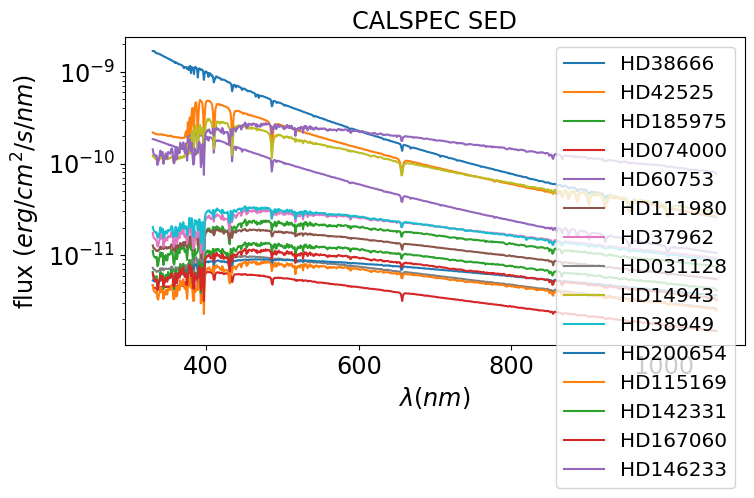

In [51]:
fig=plt.figure(figsize=(8,4))
ax=fig.add_subplot(1,1,1)

for targetid, f_sed  in dict_f_sed.items():

    sed = f_sed(WLEXTENDED)
    sed_m=-2.5*np.log10(sed)
    
    label= f"{targetid}"
    ax.plot(WLEXTENDED,sed,label=label)
    
ax.set_xlabel("$\\lambda (nm)$")
ax.set_ylabel("flux $(erg/cm^2/s/nm)$")
ax.set_title("CALSPEC SED")
ax.set_yscale('log')
ax.legend(loc='upper right')
#ax2=ax.twinx()
#ax2.plot(sed_w,sed_m,'r-')
#ax2.set_ylabel("mag")

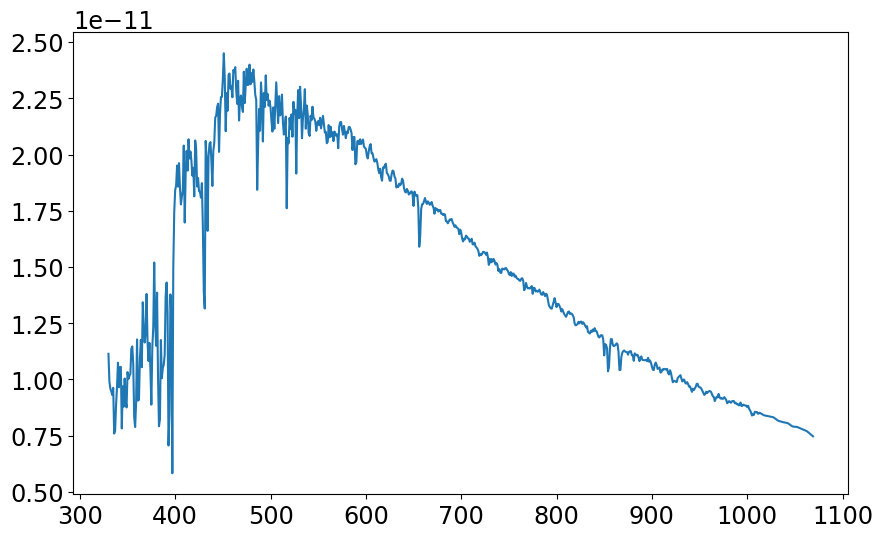

In [52]:
f_sed = dict_f_sed["HD185975"]

plt.plot(WLEXTENDED,f_sed(WLEXTENDED))

## Smooth the SED

In [53]:
dict_f_sed_sm = {}
span1 = 3
span2 = 5

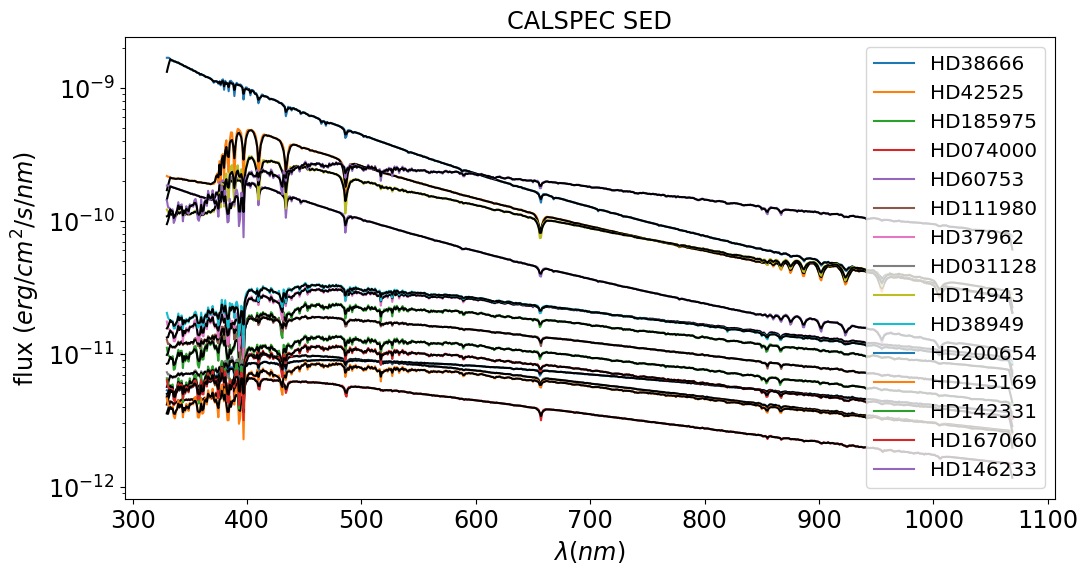

In [54]:
fig=plt.figure(figsize=(12,6))
ax=fig.add_subplot(1,1,1)

for targetid, f_sed  in dict_f_sed.items():

    sed = f_sed(WLEXTENDED)
    sed_m=-2.5*np.log10(sed)
    
 
    sed_sm1 = smooth_data_np_convolve(sed,span1)
    sed_sm2 = smooth_data_np_convolve(sed,span2)
    
    sed_sm = 0.5*(sed_sm1+sed)
    #sed_sm[330:] = sed_sm2[330:]
    
    sed_sm_m=-2.5*np.log10(sed_sm)
    
    label= f"{targetid}"
    ax.plot(WLEXTENDED,sed,label=label)
    ax.plot(WLEXTENDED,sed_sm,'k-')
    
    
    # interpolation function
    f_sed_sm = interpolate.interp1d(WLEXTENDED,sed_sm,bounds_error=False,fill_value="extrapolate")
    
    dict_f_sed_sm[targetid] = f_sed_sm 

    
ax.set_xlabel("$\\lambda (nm)$")
ax.set_ylabel("flux $(erg/cm^2/s/nm)$")
ax.set_title("CALSPEC SED")
ax.set_yscale('log')
ax.legend(loc='upper right')
#ax2=ax.twinx()
#ax2.plot(sed_w,sed_m,'r-')
#ax2.set_ylabel("mag")

In [55]:
dict_f_sed = dict_f_sed_sm

# Throughputs

## Auxtel Fittable throughput 

In [56]:
path_th = "dataout/throughput-2023-01-18-empty~holo4_003-psf2dffm-multifitatmparams-polar.csv"

th = Throughput(path_th)

th.printinfo()
x_th = WL
y_th,ey_th = th.fitthrouputwithgp(x_th)


Throughputinfo : Throughput
Total number of points 670
	 wl  =  [355. 356. 357. 358. 359.]
	 th  =  [0.00917598 0.00920563 0.00930466 0.00947106 0.00970285]
	 eth =  [0.00042481 0.00043311 0.00044499 0.00045928 0.00047523]


Text(0.5, 1.0, 'auxtel throughput')

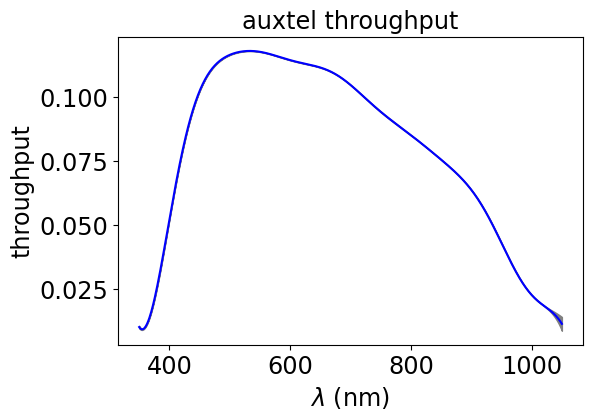

In [57]:
fig=plt.figure(figsize=(6,4))
ax=fig.add_subplot(111)
ax.plot(x_th,y_th,"b-")
ax.fill_between(x_th, y_th-ey_th, y_th+ey_th,color="grey")
ax.set_xlabel("$\\lambda$ (nm)")
ax.set_ylabel("throughput")
ax.set_title("auxtel throughput")

In [58]:
# interpolation function
f_thr = interpolate.interp1d(x_th,y_th,bounds_error=False,fill_value="extrapolate")

## spectrum data

In [59]:
fullfilename=os.path.join(inputdir,inputfile)

In [60]:
#with open(fullfilename, 'rb') as f:
#    summary_content = pickle.load(f)

In [61]:
hf =  h5py.File(fullfilename, 'r') 
list_of_keys = list(hf.keys())

In [62]:
#NBSPECTRA=len(summary_content)
NBSPECTRA=len(list_of_keys)

In [63]:
msg=f" Number of selected files is {NBSPECTRA}"
logger.info(msg)

2023-08-26 18:58:39,294 iMac-de-Sylvie.local __main__[7958] INFO  Number of selected files is 22


In [64]:
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NBSPECTRA)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NBSPECTRA), alpha=1)

### Read all files

In [65]:
normalisationfactor

1.0

In [66]:
#infos, all_spectra = GetSpectra(summary_content,factor = normalisationfactor)
infos, all_spectra = GetSpectraH5(hf,factor = normalisationfactor)

In [67]:
N=len(infos)

In [68]:
NX=4
NY=N/NX

In [69]:
if NY != int(NY):
    NY= int(NY)+1
else:
    NY=int(NY)

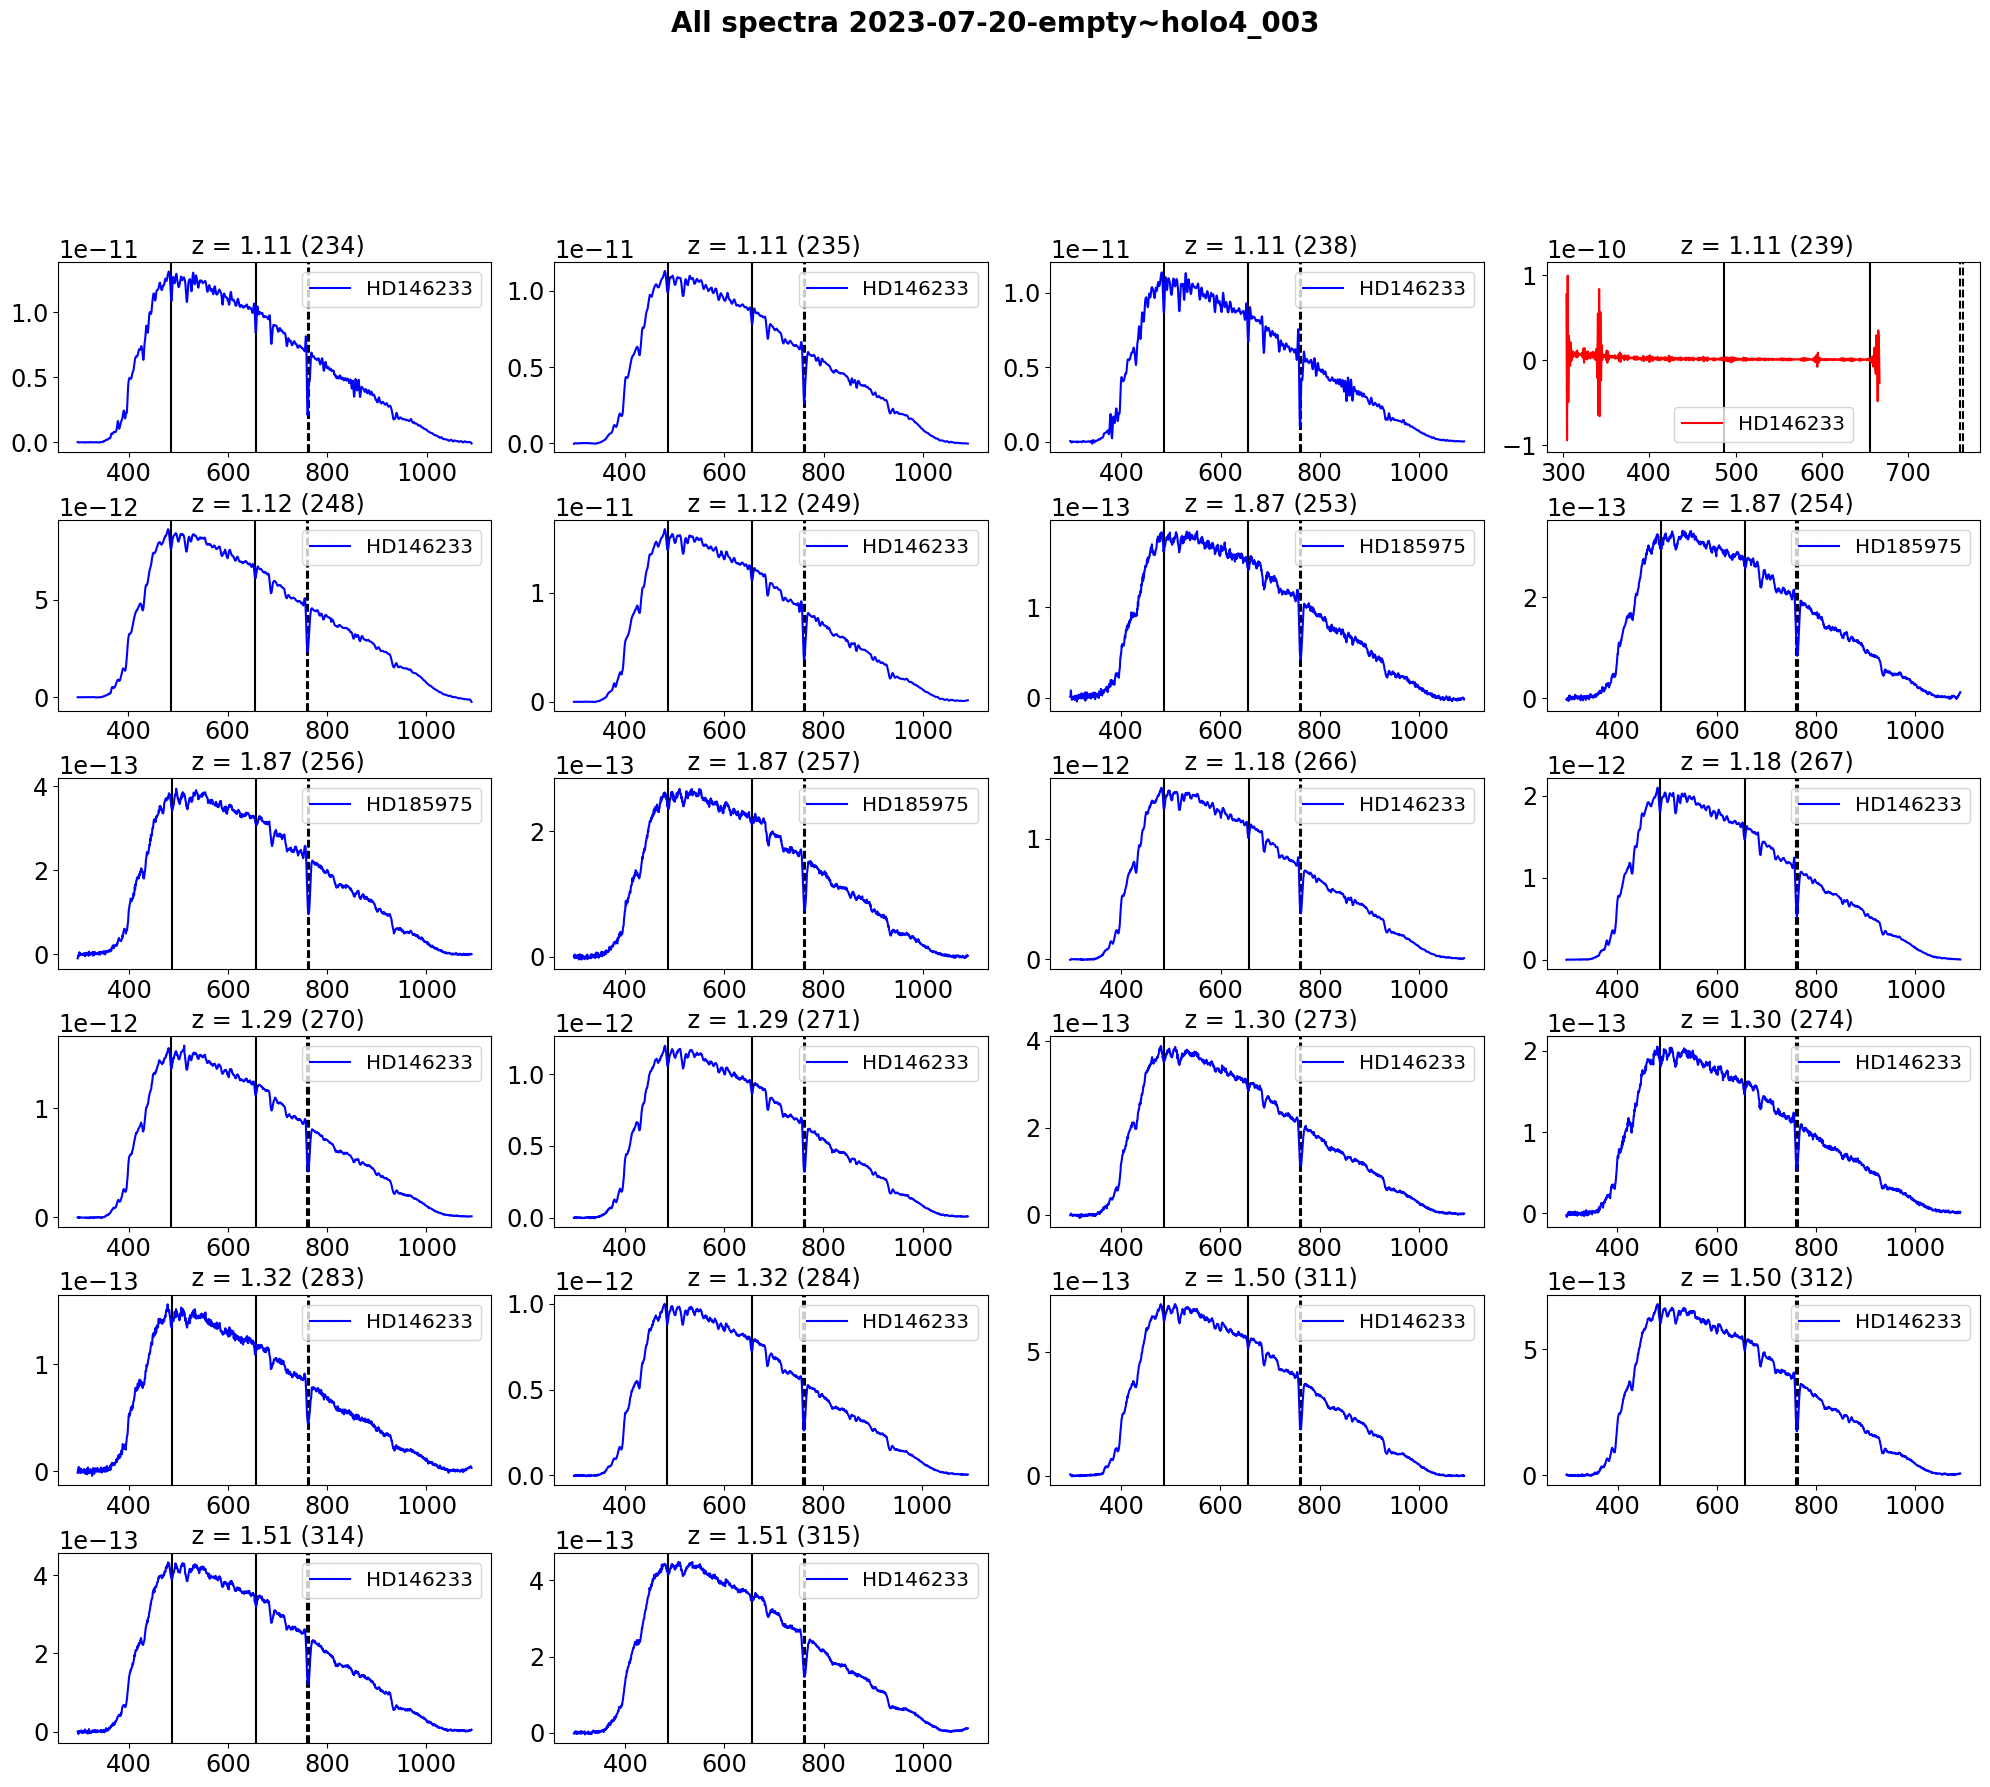

In [70]:
fig = plt.figure(figsize=(20,NY*3))

ny=0
nx=0

for idx in range(N):
    iy = idx//NX
    ix = (idx-iy*NX)
    
    ax=fig.add_subplot(NY,NX,idx+1)
    
    
    
    the_df=all_spectra[idx]
    
    airmassvalue = infos.iloc[idx]["spec_header_airmass"]
    num = infos.iloc[idx]["number"]
    label_airmass = f" z = {airmassvalue:.2f} ({num})"
    the_target = infos.iloc[idx]["spec_target_label"]
    
    #ax.plot(the_df.wavelength,the_df.flux,color=all_colors[ifile])
    if num in list_of_badnums1:
        thecolor="r"
    else:
        thecolor="b"
    
    ax.errorbar(the_df["all_lambdas"],the_df['all_fluxes'],yerr=the_df["all_fluxes_err"], fmt = '-', color=thecolor,capsize = 0.01, ecolor="k", elinewidth = .01,label=the_target)
    ax.set_title(label_airmass)
    
    ax.axvline(HBETA.wavelength,linestyle="-",color="k")
    ax.axvline(HALPHA.wavelength,linestyle="-",color="k")
    
    # O2 line
    ax.axvline(O2_1.wavelength,linestyle="--",color="k")
    #ax.annotate(O2_1.label, xy=(O2_1.wavelength-5, FLUXLIMMAX/2), color='blue',fontsize=20,fontweight='bold')

    ax.axvline(O2_2.wavelength,linestyle="--",color="k")
    #ax.annotate(O2_2.label, xy=(O2_2.wavelength, ypos), color='blue',fontsize=20,fontweight='bold')
    
    ax.legend()
    
the_title = f"All spectra {DATE}-{filterdisperser}"

plt.suptitle(the_title,size=20,fontweight='bold',y=0.99)    
plt.tight_layout()
plt.subplots_adjust(top=0.85)

fig_filename = f"fig_01-{DATE}-{filterdisperser}-allspectra.pdf"
plt.savefig(fig_filename)
plt.show()

# Remove bad Spectra

Text(0.5, 1.0, 'nb of spectra per target before spectra selection ')

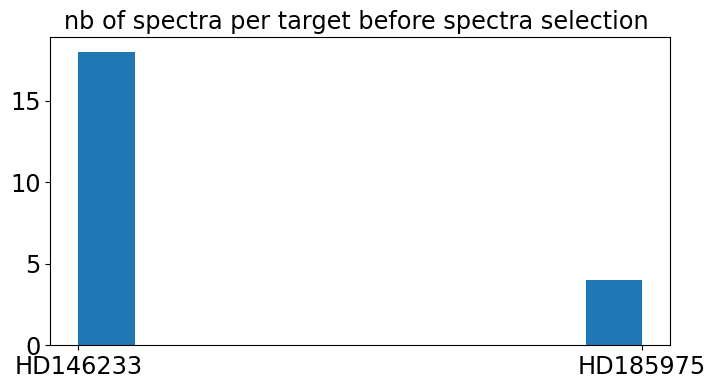

In [71]:
fig = plt.figure(figsize=(8,4))
ax=fig.add_subplot(1,1,1)
ax.hist(infos.spec_target_label);
#ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='center')
ax.set_title("nb of spectra per target before spectra selection ")

Text(0.5, 0.98, 'Variables to apply selection')

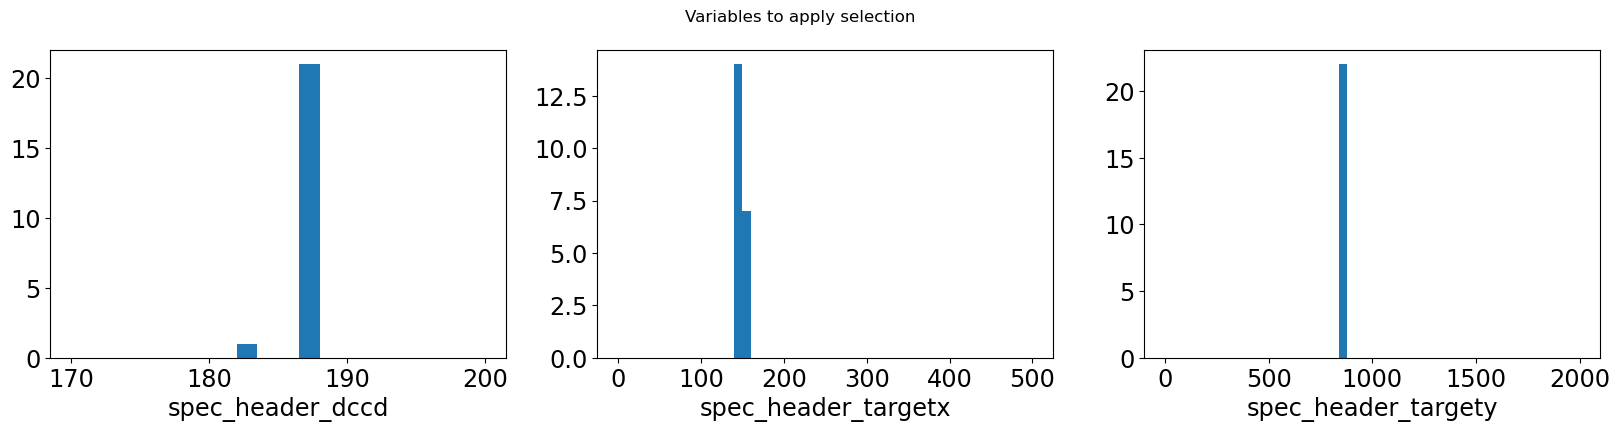

In [72]:
fig = plt.figure(figsize=(20,4))
ax=fig.add_subplot(1,3,1)
ax.hist(infos.spec_header_d2ccd,bins=20,range=(170,200));
ax.set_xlabel("spec_header_dccd")
ax=fig.add_subplot(1,3,2)
ax.hist(infos.spec_header_targetx,bins=50,range=(0,500));
ax.set_xlabel("spec_header_targetx")
ax=fig.add_subplot(1,3,3)
ax.hist(infos.spec_header_targety,bins=50,range=(0,2000));
ax.set_xlabel("spec_header_targety")
plt.suptitle("Variables to apply selection")

## Define selection cut

In [73]:
#selection_cut = ((infos.d2ccd > 178) & (infos.d2ccd < 182)) & (infos.object == target)
selection_cut = ((infos.spec_header_d2ccd > 178) & (infos.spec_header_d2ccd < 182))
bad_cut = ~selection_cut

In [74]:
list_of_badnums2 = infos[bad_cut]["number"].values
list_of_badnums2 

array([234, 235, 238, 239, 248, 249, 253, 254, 256, 257, 266, 267, 270,
       271, 273, 274, 283, 284, 311, 312, 314, 315])

In [75]:
list_of_badnums2  = np.array([])

#### Remove some targets

In [76]:
AA = infos["spec_target_label"] == "HD115169"
AB = infos["spec_target_label"] == "HD142331"
AC = infos["spec_target_label"] == "HD146233"
AD = infos["spec_target_label"] == "HD42525"
AE = infos["spec_target_label"] == "HD73495"
AF = infos["spec_target_label"] == "HD167060"
AG = infos["spec_target_label"] == "HD111980"
AH = infos["spec_target_label"] == "HD200654"
AI = infos["spec_target_label"] == "HD60753"
AJ = infos["spec_target_label"] == "HD38949" 	
AK = infos["spec_target_label"] == "HD38666" 
AL = infos["spec_target_label"] == "HD38949"
AM = infos["spec_target_label"] == "HD031128" 	
AN = infos["spec_target_label"] == "HD14943"
AO = infos["spec_target_label"] == "HD074000"
AP = infos["spec_target_label"] == "HD2811" 	
AQ = infos["spec_target_label"] == "HD009051"
AR = infos["spec_target_label"] == "HD205905" 
AS = infos["spec_target_label"] == "HD37962" 	

 	
if FLAG_POLAR:
    selection_cut3 =  AA | AB | AC | AD | AE | AF | AG | AH | AI | AJ | AK | AL | AM | AN | AO | AP | AQ | AR | AS
else:
    selection_cut3 =    AE 
list_of_badnum3 = infos[selection_cut3]["number"].values

In [77]:
list_of_badnum3

array([234, 235, 238, 239, 248, 249, 266, 267, 270, 271, 273, 274, 283,
       284, 311, 312, 314, 315])

# Union of badnums

In [78]:
list_of_badnums = np.union1d(list_of_badnums1,list_of_badnums2)
list_of_badnums = np.union1d(list_of_badnums,list_of_badnum3)
list_of_badnums=np.unique(list_of_badnums)

# Filtered spectra : remove bad spectra

In [79]:
print(list_of_badnums)

[234. 235. 238. 239. 248. 249. 266. 267. 270. 271. 273. 274. 283. 284.
 311. 312. 314. 315.]


In [80]:
#infos, all_spectra = GetSpectraFiltered(summary_content,list_of_bad_spectra=list_of_badnums,factor = normalisationfactor)
infos, all_spectra = GetSpectraH5Filtered(hf,list_of_bad_spectra = list_of_badnums , factor = normalisationfactor)

/var/folders/cq/vms8st5136z3q5xx4rd9xqfr0000gw/T/ipykernel_7958/3360277674.py:21: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if seq not in list_of_bad_spectra and str(seq) not in list_of_bad_spectra:


In [81]:
# infos["number"] = infos[['exposure']].apply(lambda x: get_seq(x))

In [82]:
print("Number of spectra : ",len(all_spectra))

Number of spectra :  4


In [83]:
infos.reset_index(drop=True, inplace=True)

In [84]:
infos

,index,exposure,expo_instrument,expo_id,physical_filter,obs_id,exposure_time,dark_time,observation_type,observation_reason,day_obs,seq_num,group_name,group_id,target_name,science_program,tracking_ra,tracking_dec,sky_angle,azimuth,zenith_angle,mjd,jd,spec_date_obs,spec_target_label,spec_filter_label,spec_airmass,spec_pressure,spec_temperature,spec_humidity,spec_hour_angle,spec_parallactic_angle,spec_camera_angle,spec_order,spec_header_target,spec_header_redshift,spec_header_grating,spec_header_rotangle,spec_header_d2ccd,spec_header_lshift,spec_header_parangle,spec_header_targetx,spec_header_targety,spec_header_lbda_ref,spec_header_pixshift,spec_header_psf_reg,spec_header_trace_r,spec_header_chi2_fit,spec_header_a2_fit,spec_header_am_fit,spec_header_meanfwhm,spec_header_version,spec_header_rebin,spec_header_date-obs,spec_header_exptime,spec_header_airmass,spec_header_dec,spec_header_ha,spec_header_outtemp,spec_header_outpress,spec_header_outhum,spec_header_filter,spec_header_cam_rot,spec_header_s_x0,spec_header_s_y0,spec_header_s_xmin,spec_header_s_xmax,spec_header_s_ymin,spec_header_s_ymax,spec_header_s_nx,spec_header_s_ny,spec_header_s_dec,spec_header_s_sat,spec_spectrogram_x0,spec_spectrogram_y0,spec_spectrogram_xmin,spec_spectrogram_xmax,spec_spectrogram_ymin,spec_spectrogram_ymax,spec_spectrogram_deg,spec_spectrogram_saturation,spec_spectrogram_Nx,spec_spectrogram_Ny,refhour,number
0,6,2023072000253,LATISS,2023072000253,empty~holo4_003,AT_O_20230720_000253,30.0,30.2377,science,generic,20230720,253,2023-07-21T02:32:05.739,2698363257390000,HD185975,spec,307.769004,-87.433803,42.623966,177.835843,57.842451,60146.108171,2.460147e+06,2023-07-21T02:35:24.114005963Z,HD185975,empty,1.872867,0,0,0,-41.355219,-42.392797,227.376034,1,HD185975,-0.000065,holo4_003,0.465649,187.382013,0.0,-42.392797,151.645654,866.696837,597.364319,0.067516,1.121534,198.334359,1.098176,1.0,1.872867,7.605272,2.4,2,2023-07-21T02:35:24.114005963Z,30.0,1.872867,-87.433803,-41.355219,0,0,0,empty,227.376034,-418.604289,83.696837,570,1706,783,968,1136,185,2,22666.666667,-418.604289,83.696837,570,1706,783,968,2,22666.666667,1136,185,0.000000,253
1,7,2023072000254,LATISS,2023072000254,empty~holo4_003,AT_O_20230720_000254,30.0,30.2375,science,generic,20230720,254,2023-07-21T02:32:05.739,2698363257390000,HD185975,spec,307.768586,-87.433818,42.624264,177.842823,57.836603,60146.108669,2.460147e+06,2023-07-21T02:36:07.125504783Z,HD185975,empty,1.872566,0,0,0,-41.175096,-42.209098,227.375736,1,HD185975,-0.000065,holo4_003,0.441077,187.193469,0.0,-42.209098,153.588335,868.228082,597.364319,-0.002258,0.690637,191.108583,1.046798,1.0,1.872566,7.550710,2.4,2,2023-07-21T02:36:07.125504783Z,30.0,1.872566,-87.433818,-41.175096,0,0,0,empty,227.375736,-417.268859,84.228082,570,1707,784,969,1137,185,2,22666.666667,-417.268859,84.228082,570,1707,784,969,2,22666.666667,1137,185,0.011944,254
2,8,2023072000256,LATISS,2023072000256,empty~holo4_003,AT_O_20230720_000256,30.0,30.2367,science,generic,20230720,256,2023-07-21T02:37:11.700,2698366317000000,HD185975,spec,307.769508,-87.433785,42.623093,177.855431,57.826045,60146.109574,2.460147e+06,2023-07-21T02:37:25.307501764Z,HD185975,empty,1.872021,0,0,0,-40.849368,-41.876899,227.376907,1,HD185975,-0.000065,holo4_003,0.452416,187.265302,0.0,-41.876899,154.714735,866.810559,597.364319,0.199310,0.867087,199.972349,1.561892,1.0,1.872021,7.885210,2.4,2,2023-07-21T02:37:25.307501764Z,30.0,1.872021,-87.433785,-40.849368,0,0,0,empty,227.376907,-416.869350,83.810559,571,1708,783,968,1137,185,2,22666.666667,-416.869350,83.810559,571,1708,783,968,2,22666.666667,1137,185,0.033611,256
3,9,2023072000257,LATISS,2023072000257,empty~holo4_003,AT_O_20230720_000257,30.0,30.2458,science,generic,20230720,257,2023-07-21T02:37:11.700,2698366317000000,HD185975,spec,307.769941,-87.433772,42.622620,177.862419,57.820249,60146.110074,2.460147e+06,2023-07-21T02:38:08.520008501Z,HD185975,empty,1.871722,0,0,0,-40.669257,-41.693191,227.377380,1,HD185975,-0.000065,holo

/var/folders/cq/vms8st5136z3q5xx4rd9xqfr0000gw/T/ipykernel_7958/2635005956.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='center')


Text(0.5, 1.0, 'nb of spectra per target after spectra selection ')

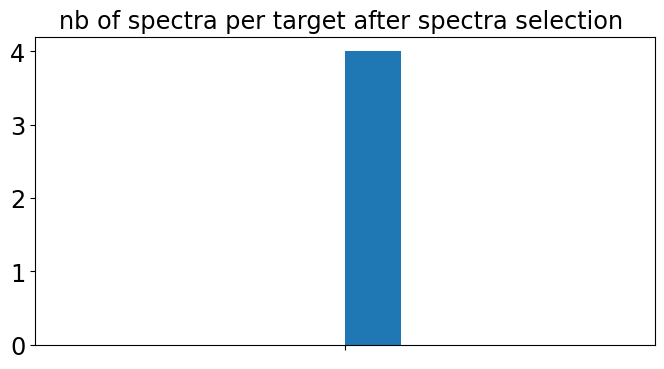

In [85]:
fig = plt.figure(figsize=(8,4))
ax=fig.add_subplot(1,1,1)
ax.hist(infos.spec_target_label);
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='center')
ax.set_title("nb of spectra per target after spectra selection ")

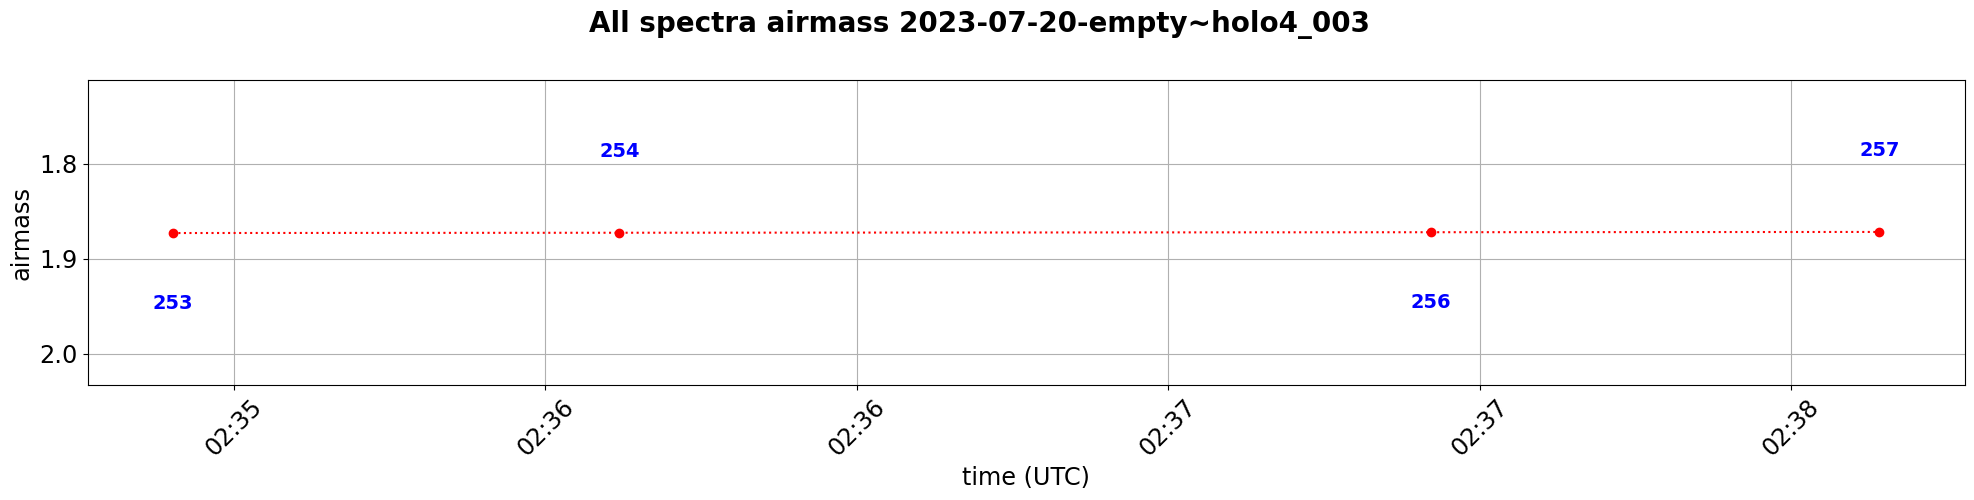

In [86]:
all_datetime = [ Time(str_time).to_datetime() for str_time in infos['spec_date_obs'] ]
numbers = infos['number'].values
airmasses = infos['spec_header_airmass'].values
N= len(numbers)

myFmt = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(myFmt)


# Create rectangle x coordinates
startTime = all_datetime[0]
endTime =  datetime(2023, 1, 31, 0, 0, 0, 0),

# convert to matplotlib date representation
start = mdates.date2num(startTime)
end = mdates.date2num(endTime)
width = end - start



fig=plt.figure(figsize=(20,5))
ax=fig.add_subplot(111)
#ax.plot(all_datetime,grey_attenuation,'bo:')
#ax.grid()
#plt.gcf().autofmt_xdate()
#ax.xaxis.set_major_formatter(myFmt)
#ax.xaxis.set_tick_params(rotation=45)
#ax.set_xlabel("time (UTC)")
#ax.set_title(f"Grey attenuation : {DATE} ({filterdisperser}, {target})")
#ax.set_ylabel("attenuation")
#ax2 = ax.twinx()

y_shift= 0.08

ax2=ax
ax2.plot(all_datetime,airmasses,'r:o')
ax2.xaxis.set_major_formatter(myFmt)
ax2.xaxis.set_tick_params(rotation=45)
ax2.set_xlabel("time (UTC)")
ax2.set_ylabel("airmass")
ax2.set_ylim(airmasses.min()-2*y_shift,airmasses.max()+2*y_shift)
# Plot rectangle
#rect = plt.Rectangle((start, airmasses.min()-2*y_shift), width, airmasses.max()+ 2*y_shift, color='grey',alpha=0.3)
#ax2.add_patch(rect)   
ax2.invert_yaxis()
ax2.grid()


for index in range(N):
    textstr= str(numbers[index])
    if index%2 == 0:
        dy = y_shift
    else:
        dy = -y_shift
            
    ax2.text(all_datetime[index], airmasses[index] + dy , textstr,fontsize=14,fontweight="bold",ha='center',color="b" )
    
the_title = f"All spectra airmass {DATE}-{filterdisperser}"
plt.suptitle(the_title,size=20,fontweight='bold',y=0.99)    
plt.tight_layout()
plt.subplots_adjust(top=0.85)

fig_filename = f"fig_02-{DATE}-{filterdisperser}-airmasses.pdf"
plt.savefig(fig_filename)
plt.show()

# Simulate atmospheric transparency

In [87]:
emul = SimpleAtmEmulator()

In [88]:
NBINFOS = len(infos)
dict_func_atm = {}
print(NBINFOS)

pwv0 = 3
oz0 = 300.
ncomp=0

for ispec in range(NBINFOS):
    the_infos = infos.iloc[ispec]
    the_airmass = the_infos["spec_header_airmass"]
    the_number = the_infos["number"]
    
    transm = emul.GetAllTransparencies(WL,the_airmass,pwv0,oz0,ncomp=ncomp,flagAerosols=False)
    dict_func_atm[the_number] = interpolate.interp1d(WL,transm,bounds_error=False,fill_value="extrapolate")

4


In [89]:
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NBINFOS)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NBINFOS), alpha=1)

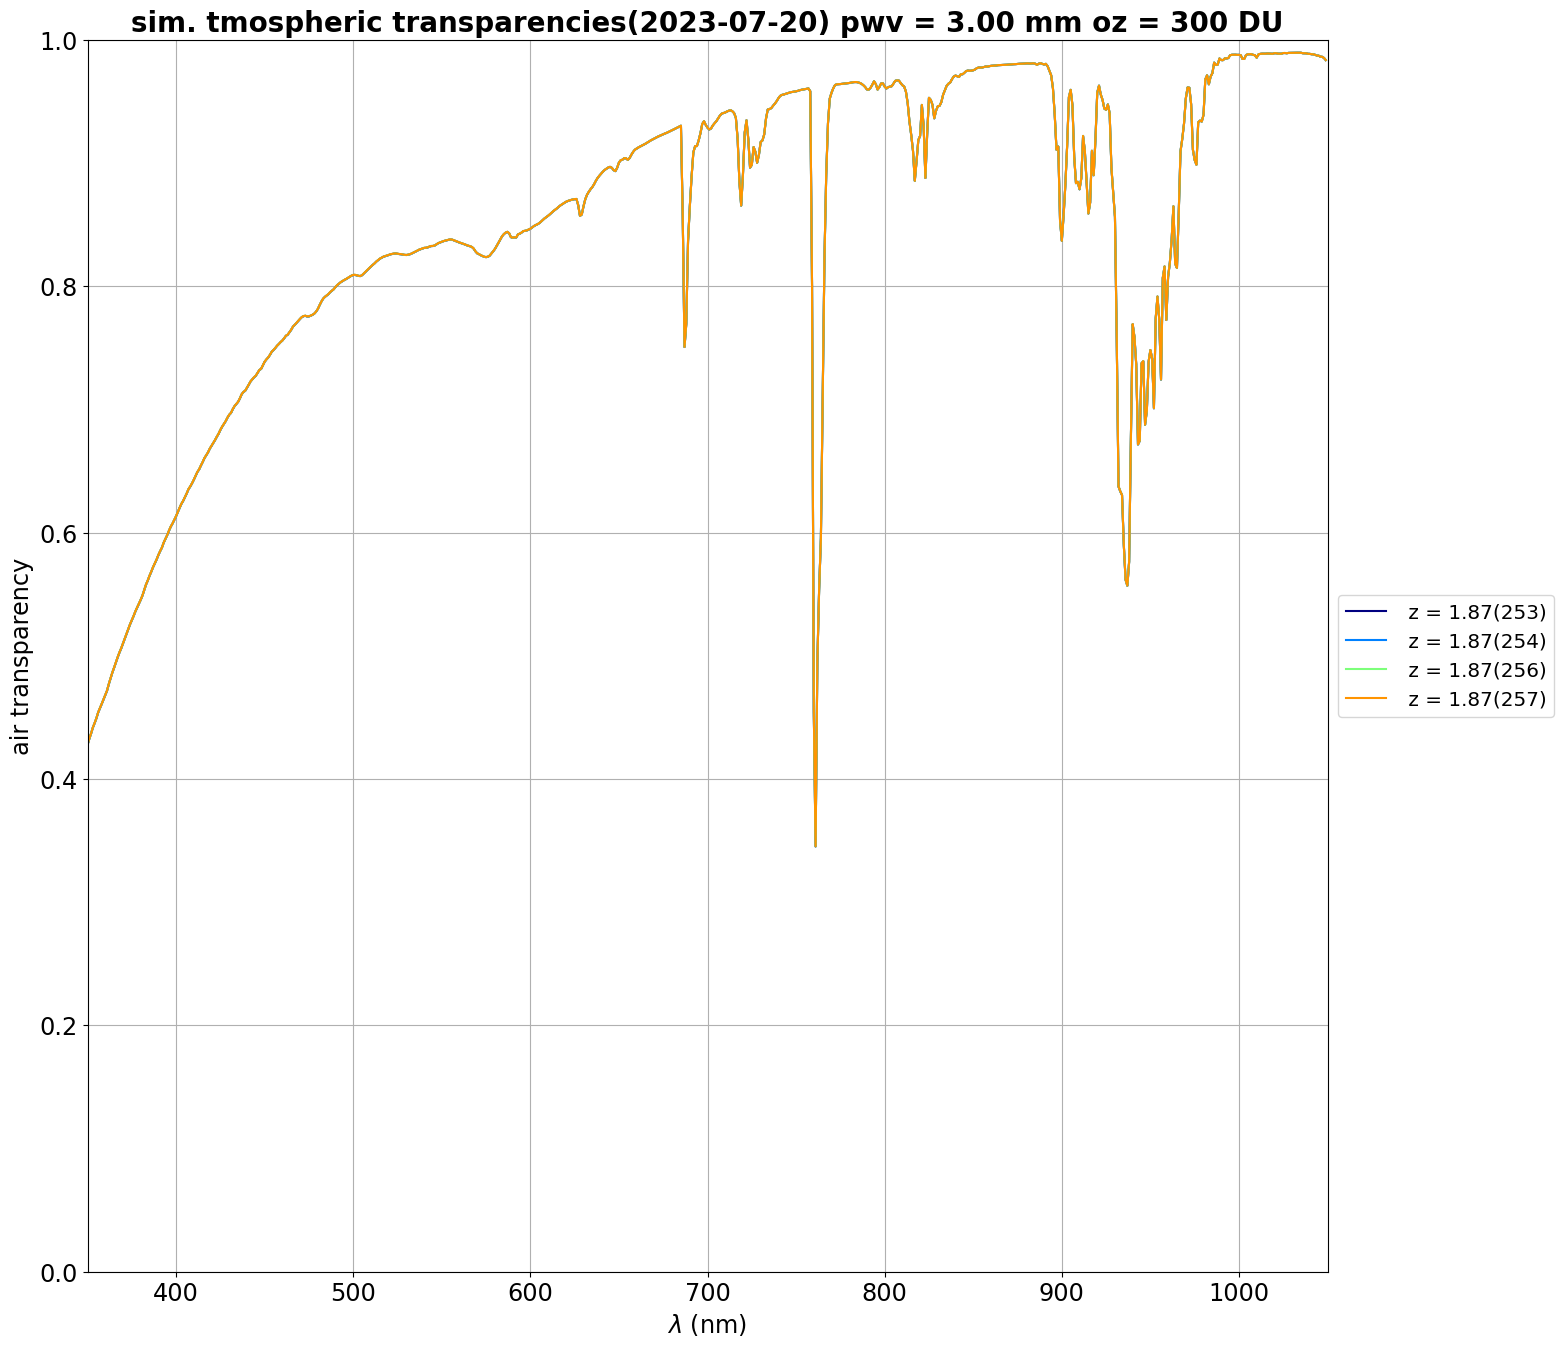

In [90]:
fig=plt.figure(figsize=(16,16))
ax=fig.add_subplot(111)
for isim in np.arange(NBINFOS):
    
    airmassvalue = infos.iloc[isim]["spec_header_airmass"]
    the_number = infos.iloc[isim]["number"]
    label_airmass = f" z = {airmassvalue:.2f}({the_number})"

    atm = dict_func_atm[the_number](WL)
    
    ax.plot(WL,atm, color=all_colors[isim],label=label_airmass)

ax.grid()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("air transparency")
title=f"sim. tmospheric transparencies({DATE}) pwv = {pwv0:.2f} mm oz = {oz0:.0f} DU"
ax.set_title(title,fontsize=20,fontweight='bold')

ax.set_xlim( WLMINSEL  , WLMAXSEL  )
ax.set_ylim(0.,1)
#ax.legend(loc="lower left",ncol=5)
#ax.legend(bbox_to_anchor=(1.02, 0.5))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))


# Plot Spectra

In [91]:
NBSPECTRA=len(all_spectra)

In [92]:
assert NBSPECTRA == NBINFOS
print(NBSPECTRA)

4


In [93]:
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NBSPECTRA)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NBSPECTRA), alpha=1)

In [94]:
msg=f" Number of good spectra is {NBSPECTRA}"
logger.info(msg)

2023-08-26 18:58:57,590 iMac-de-Sylvie.local __main__[7958] INFO  Number of good spectra is 4


### load absorption pattern

In [95]:
df = pd.read_csv("data/absorption_pattern.csv")
wlpt,o2,o3,h2o,no2 = atmpatt_Dataf_to_np(df)

In [96]:
def plotlines(ax,ypos):
    
    ax.axvline(HDELTA.wavelength,color='orange')
    ax.annotate(HDELTA.label, xy=(HDELTA.wavelength, ypos), color='orange',fontsize=20,fontweight='bold')
    
    ax.axvline(HGAMMA.wavelength,color='orange')
    ax.annotate(HGAMMA.label, xy=(HGAMMA.wavelength, ypos), color='orange',fontsize=20,fontweight='bold')
    
    ax.axvline(HBETA.wavelength,color='orange')
    ax.annotate(HBETA.label, xy=(HBETA.wavelength, ypos), color='orange',fontsize=20,fontweight='bold')
    
    ax.axvline(HALPHA.wavelength,color='orange')
    ax.annotate(HALPHA.label, xy=(HALPHA.wavelength, ypos), color='orange',fontsize=20,fontweight='bold')

    ax.axvline(O2B.wavelength,color="blue")
    ax.annotate(O2B.label, xy=(O2B.wavelength, ypos), color='blue',fontsize=20,fontweight='bold')

    ax.axvline(O2_1.wavelength,color="blue")
    #ax.annotate(O2_1.label, xy=(O2_1.wavelength-5, FLUXLIMMAX/2), color='blue',fontsize=20,fontweight='bold')

    ax.axvline(O2_2.wavelength,color="blue")
    ax.annotate(O2_2.label, xy=(O2_2.wavelength, ypos), color='blue',fontsize=20,fontweight='bold')

    ax.axvline(H2O_1.wavelength,color="blue")
    ax.annotate(H2O_1.label, xy=(H2O_1.wavelength, ypos), color='blue',fontsize=20,fontweight='bold')
    
    ax.axvline(H2O_2.wavelength,color="blue")
    ax.annotate(H2O_2.label, xy=(H2O_2.wavelength, ypos), color='blue',fontsize=20,fontweight='bold')
    

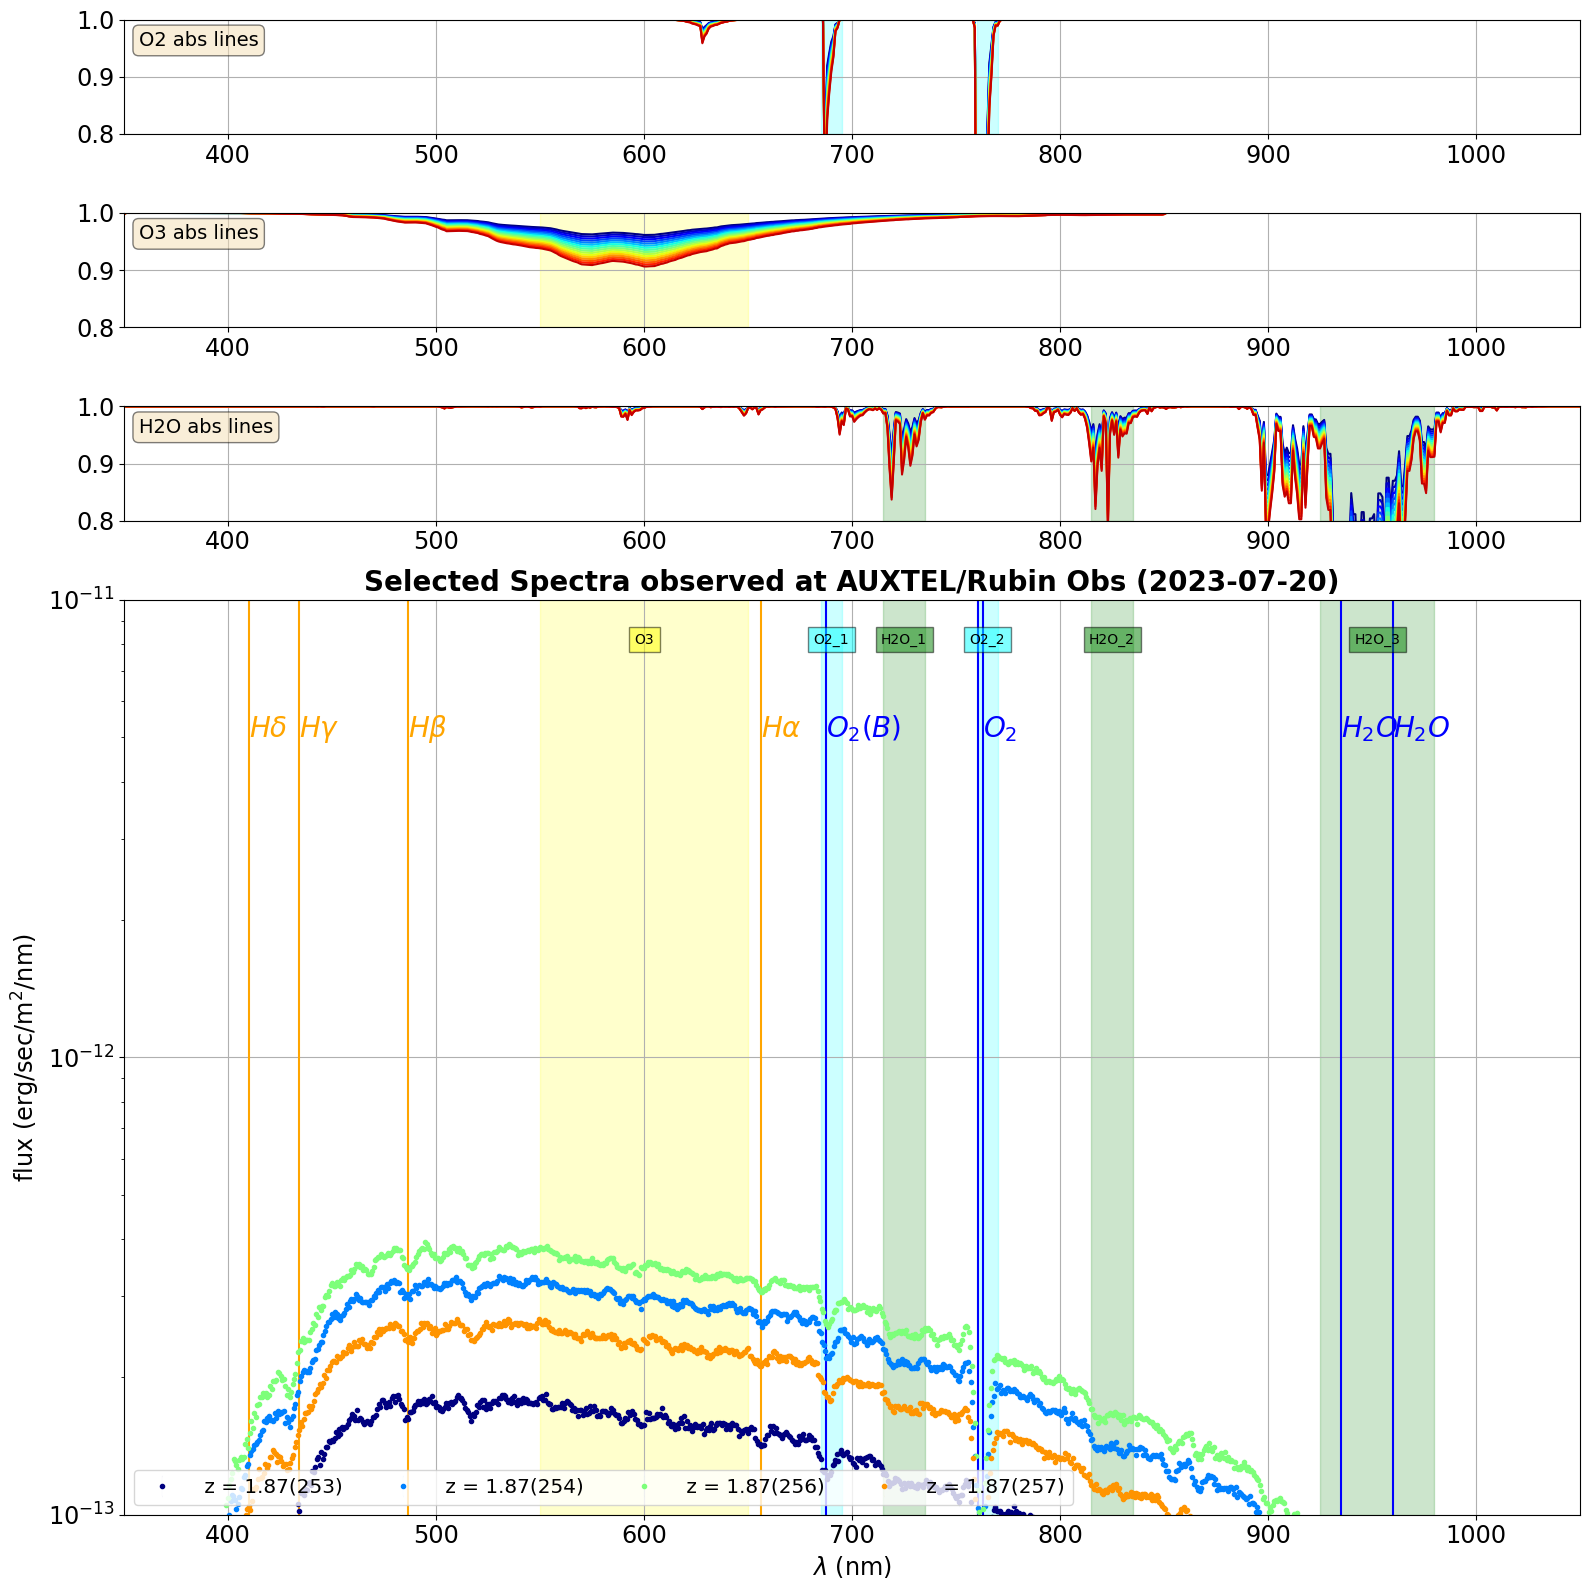

In [97]:
figsize=(16,16)

NOBS = o2.shape[1]
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NOBS)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NOBS), alpha=1)

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

fig=plt.figure(figsize=figsize)
title =f"Spectra (hologram) {SITE} ({DATE})"


#gs = gridspec.GridSpec(5, 1,height_ratios=[0.5,0.5,0.5,0.5,4] ,figure=fig)
gs = gridspec.GridSpec(4, 1,height_ratios=[0.5,0.5,0.5,4] ,figure=fig)

#=========================================================== NO2    
#ax=fig.add_subplot(gs[0,0])
#for index in np.arange(NOBS):   
#    ax.plot(wlpt,no2[:,index],'-',color=all_colors[index])
#ax.set_ylim(0.8,1)
#ax.set_xlim(WLMINSEL,WLMAXSEL)
#ax.grid()
#textstr = "NO2 abs lines"
# place a text box in upper left in axes coords
#ax.text(0.01, 0.90, textstr, transform=ax.transAxes, fontsize=14,
#        verticalalignment='top', bbox=props)
#ax.set_title(title,fontsize=20,fontweight='bold')
#main_ax = ax



#=========================================================== O2    
#ax=fig.add_subplot(gs[0,0], sharex=main_ax)
the_ymin = 0.8
the_ymax = 1

ax=fig.add_subplot(gs[0,0])
for index in np.arange(NOBS):   
    ax.plot(wlpt,o2[:,index],'-',color=all_colors[index])
ax.set_ylim(the_ymin,the_ymax)
ax.set_xlim(WLMINSEL,WLMAXSEL)
ax.grid()
textstr = "O2 abs lines"
# place a text box in upper left in axes coords
ax.text(0.01, 0.90, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
#ax.set_title(title)

for item in dict_absbands.items():
    key = item[0]
    val = item[1]
    idx_abscolor = val[2] 
    if idx_abscolor == 1:
        rect = Rectangle((val[0],the_ymin),val[1]-val[0],the_ymax,linewidth=1,edgecolor=absbands_colors[idx_abscolor],facecolor=absbands_colors[idx_abscolor],alpha=0.2)
        ax.add_patch(rect)

main_ax = ax

#=========================================================== Ozone
ax=fig.add_subplot(gs[1,0], sharex=main_ax)
the_ymin = 0.8
the_ymax = 1.0
for index in np.arange(NOBS):   
    ax.plot(wlpt,o3[:,index],'-',color=all_colors[index])
ax.set_ylim(the_ymin,the_ymax)
ax.set_xlim(WLMINSEL,WLMAXSEL)
ax.grid()
textstr = "O3 abs lines"
# place a text box in upper left in axes coords
ax.text(0.01, 0.90, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
for item in dict_absbands.items():
    key = item[0]
    val = item[1]
    idx_abscolor = val[2] 
    if idx_abscolor == 0:
        rect = Rectangle((val[0],the_ymin),val[1]-val[0],the_ymax,linewidth=1,edgecolor=absbands_colors[idx_abscolor],facecolor=absbands_colors[idx_abscolor],alpha=0.2)
        ax.add_patch(rect)

#=========================================================== H2O
ax=fig.add_subplot(gs[2,0], sharex=main_ax)
the_ymin = 0.8
the_ymax = 1.
for index in np.arange(NOBS):   
    ax.plot(wlpt,h2o[:,index],'-',color=all_colors[index])
ax.set_ylim(the_ymin,the_ymax)
ax.grid()
textstr = "H2O abs lines"
# place a text box in upper left in axes coords
ax.text(0.01, 0.90, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

for item in dict_absbands.items():
    key = item[0]
    val = item[1]
    idx_abscolor = val[2] 
    if idx_abscolor == 2:
        rect = Rectangle((val[0],the_ymin),val[1]-val[0],the_ymax,linewidth=1,edgecolor=absbands_colors[idx_abscolor],facecolor=absbands_colors[idx_abscolor],alpha=0.2)
        ax.add_patch(rect)

#================================================= spectra
ax=fig.add_subplot(gs[3,0], sharex=main_ax)

# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NBSPECTRA)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NBSPECTRA), alpha=1)
all_numbers = infos['number'].values



for ifile in np.arange(NBSPECTRA):
    the_df=all_spectra[ifile]
    
    airmassvalue = infos.iloc[ifile]["spec_header_airmass"]
    the_number = all_numbers[ifile]
    label_airmass = f" z = {airmassvalue:.2f}({the_number})"

    #ax.plot(the_df.wavelength,the_df.flux,color=all_colors[ifile])
    ax.errorbar(the_df["all_lambdas"],the_df['all_fluxes'],yerr=the_df["all_fluxes_err"], fmt = '.', color=all_colors[ifile],capsize = 0.01, ecolor=all_colors[ifile], elinewidth = .01,label=label_airmass)
ax.grid()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("flux (erg/sec/m$^2$/nm)")
title=f"Selected Spectra observed at {SITE} ({DATE})"
ax.set_title(title,fontsize=20,fontweight='bold')
#ax.plot(sed_w,sed_f,'k-')
#ax.set_xlim(350,1000)
#ax.set_ylim(1e-14,1e-10)
ax.set_ylim(FLUXLIMMIN,FLUXLIMMAX)
ax.set_yscale("log")
ax.legend(loc="lower left",ncol=6)
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

the_ymin = FLUXLIMMIN
the_ymax = FLUXLIMMAX
the_yscale = the_ymax  - the_ymin 
        
for item in dict_absbands.items():
    key = item[0]
    val = item[1]
    idx_abscolor = val[2] 
    the_x = (val[0]+val[1])/2.
    the_y = the_ymax - 0.2* the_yscale
    rect = Rectangle((val[0],the_ymin),val[1]-val[0],the_ymax,linewidth=1,edgecolor=absbands_colors[idx_abscolor],facecolor=absbands_colors[idx_abscolor],alpha=0.2)
    ax.add_patch(rect)
    ax.text(the_x, the_y, key, horizontalalignment='center',bbox=dict(facecolor=absbands_colors[idx_abscolor], alpha=0.5))
    

# draw abs lines
plotlines(ax,ypos=FLUXLIMMAX/2)

plt.tight_layout()


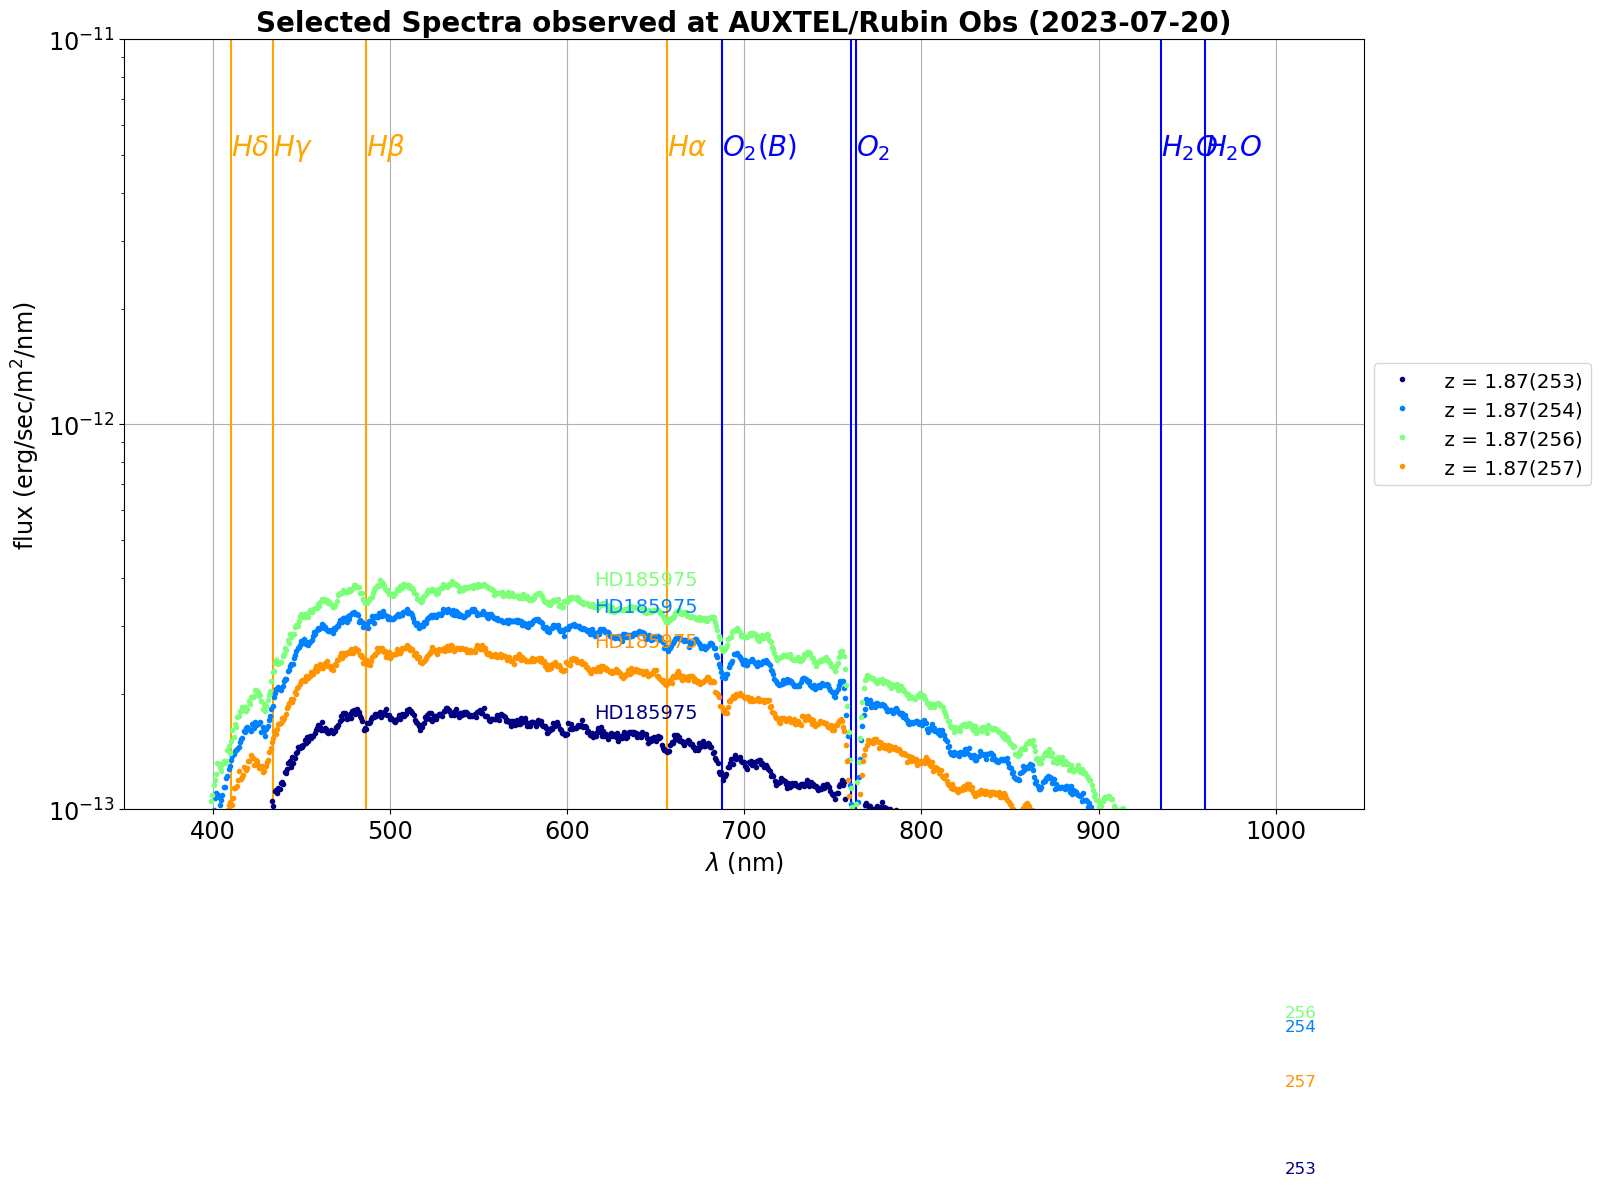

In [98]:
fig=plt.figure(figsize=(16,10))
ax=fig.add_subplot(111)
for ifile in np.arange(NBSPECTRA):
    the_df=all_spectra[ifile]
    
    airmassvalue = infos.iloc[ifile]["spec_header_airmass"]
    the_number = all_numbers[ifile]
    label_airmass = f" z = {airmassvalue:.2f}({the_number})"

    #ax.plot(the_df.wavelength,the_df.flux,color=all_colors[ifile])
    ax.errorbar(the_df["all_lambdas"],the_df['all_fluxes'],yerr=the_df["all_fluxes_err"], fmt = '.', color=all_colors[ifile],capsize = 0.01, ecolor=all_colors[ifile], elinewidth = .01,label=label_airmass)

    f_flux = interpolate.interp1d(the_df["all_lambdas"].values,the_df['all_fluxes'].values,bounds_error=False,fill_value=0)
    x1=1000.
    y1=f_flux(x1)
    s1=str(the_number)
    x2=600
    y2=f_flux(x2)
    s2=infos.iloc[ifile]["spec_target_label"]
    ax.text(x1+5, y1, s1, color=all_colors[ifile],fontsize=12)
    ax.text(x2+15, y2*1.1, s2, color=all_colors[ifile],fontsize=14)
    
ax.grid()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("flux (erg/sec/m$^2$/nm)")
title=f"Selected Spectra observed at {SITE} ({DATE})"
ax.set_title(title,fontsize=20,fontweight='bold')
#ax.plot(sed_w,sed_f,'k-')
ax.set_xlim( WLMINSEL  , WLMAXSEL  )
ax.set_ylim(FLUXLIMMIN,FLUXLIMMAX)
ax.set_yscale("log")
#ax.legend(loc="lower left",ncol=5)
#ax.legend(bbox_to_anchor=(1.02, 0.5))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# draw abs lines
plotlines(ax,ypos=FLUXLIMMAX/2)


In [99]:
#correction_area = 1.06/1.13
correction_area = 1

In [100]:
#sed_predicted_f = f_sed(WL) * f_thr(WL) * f_atm(WL) 
#sed_predicted_m = -2.5*np.log10(sed_predicted_f) 

# Fit

## Select the identifier

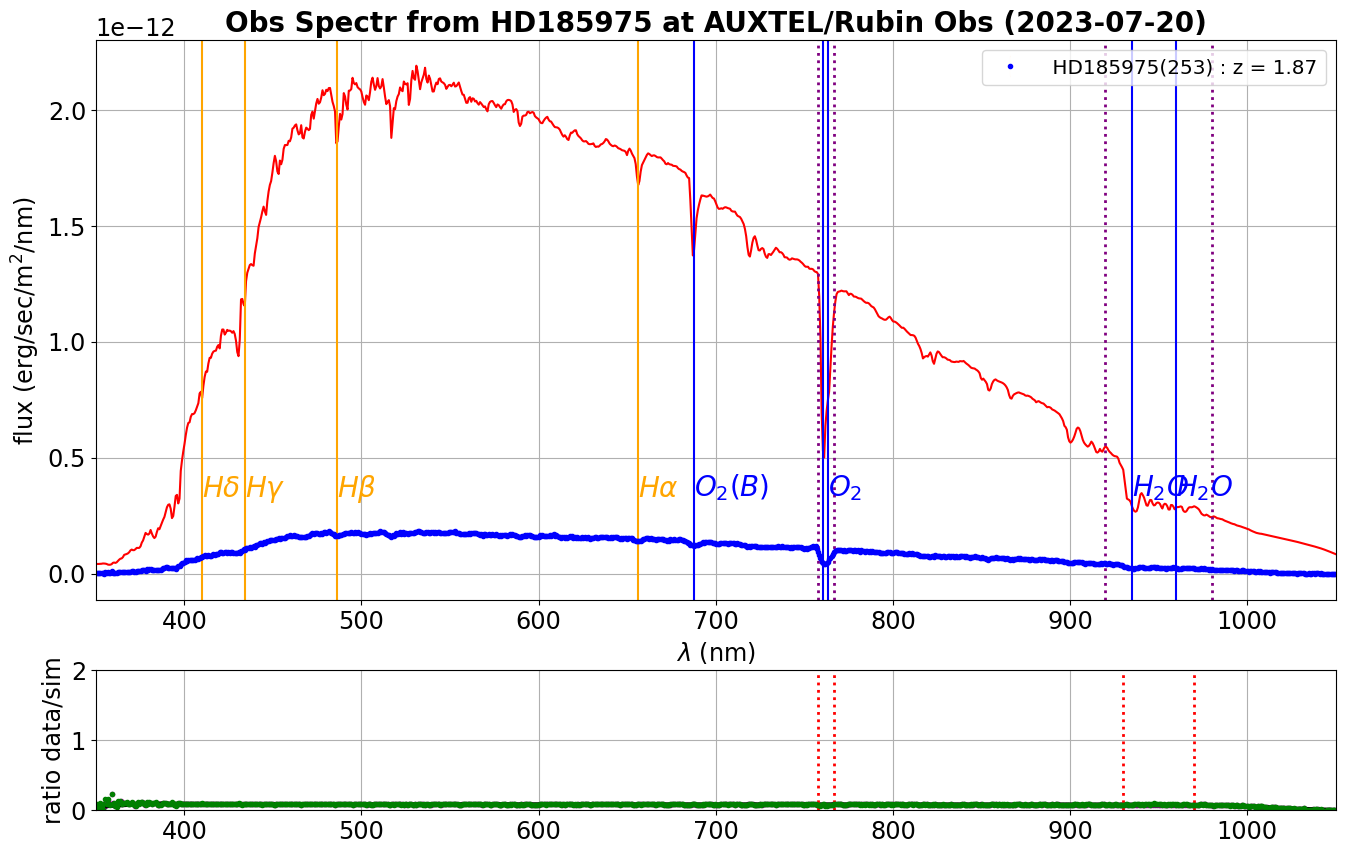

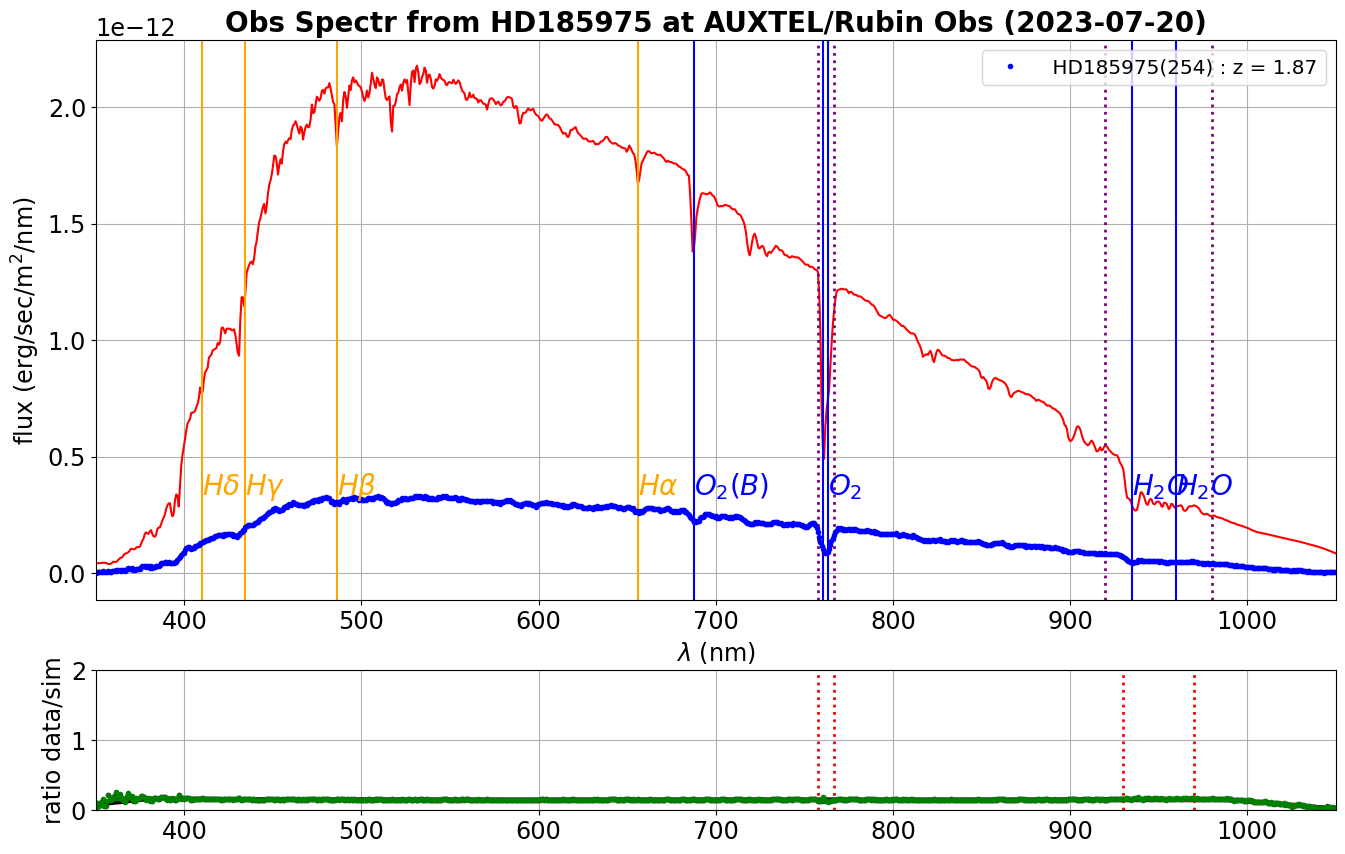

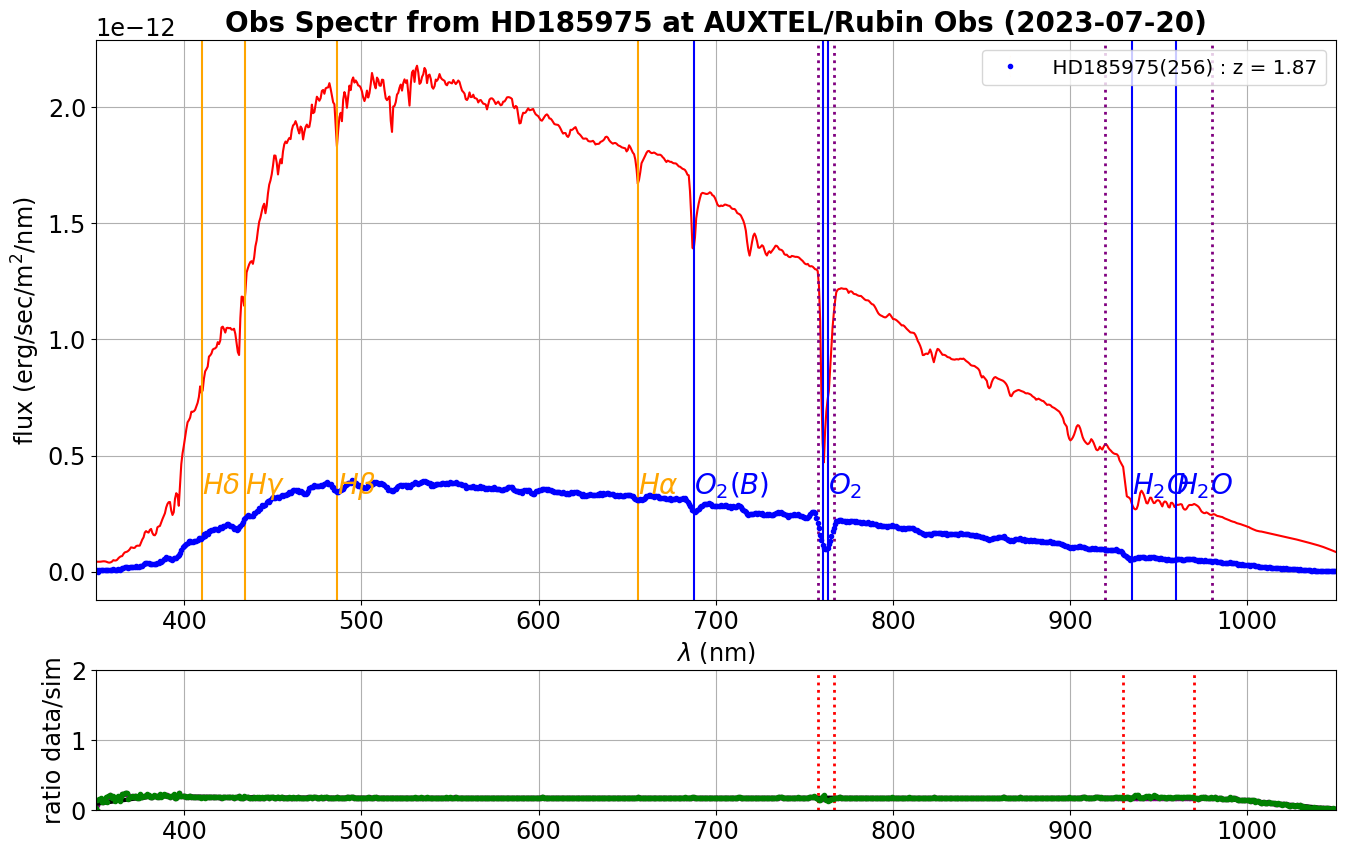

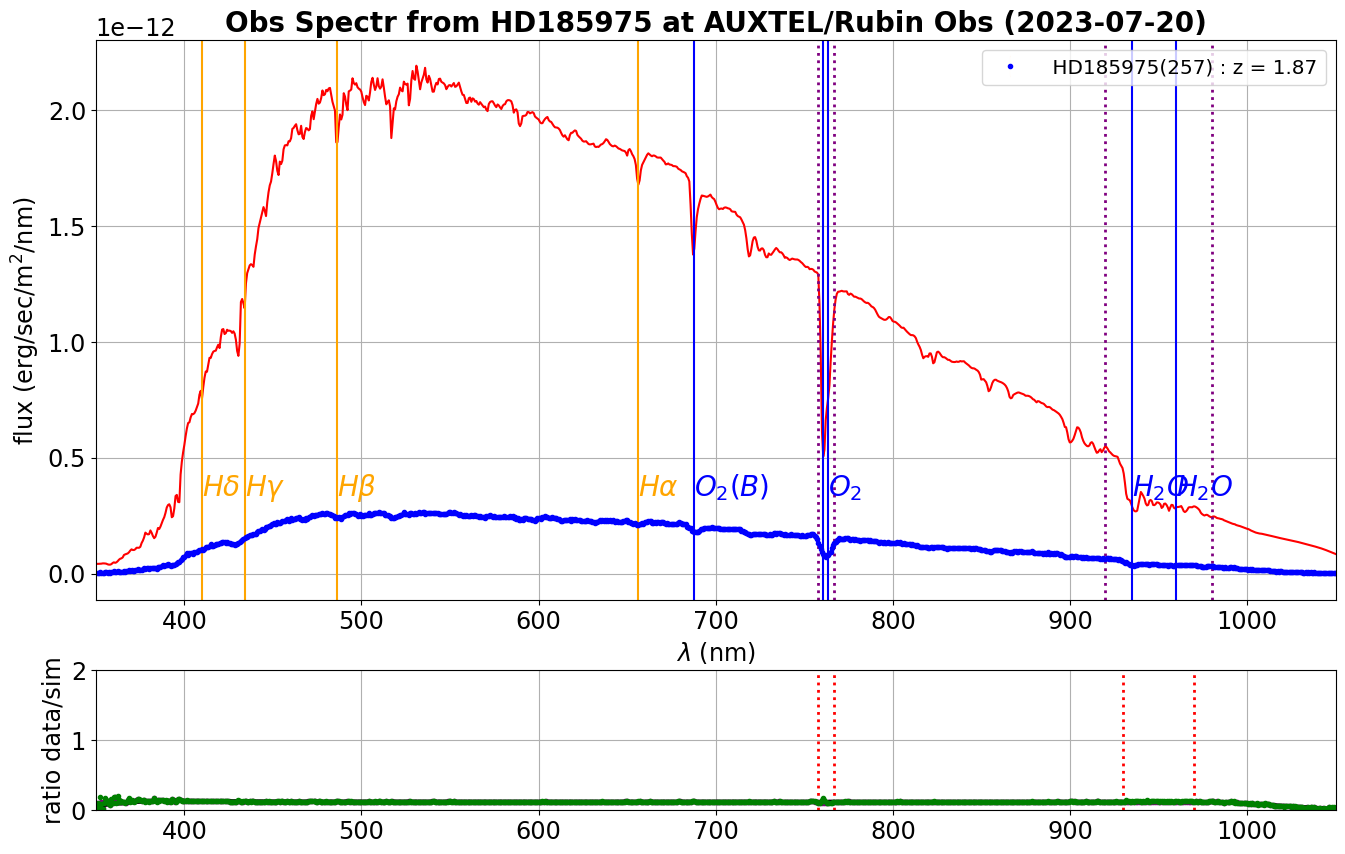

In [101]:
dict_ratio = {}
array_ratio = np.zeros((NBSPECTRA,len(WL)))

for idx in range(NBSPECTRA):
    
    fig=plt.figure(figsize=(16,10))
    gs = gridspec.GridSpec(2, 1,height_ratios=[4,1] ,figure=fig)


    # Fig 1
    ax=fig.add_subplot(gs[0,0])

    # extract spectrum from data
    the_df=all_spectra[idx]
    the_number = infos.iloc[idx]["number"]
    airmassvalue = infos.iloc[idx]["spec_header_airmass"]
    target = infos.iloc[idx]["spec_target_label"]
    label_airmass = f" {target}({the_number}) : z = {airmassvalue:.2f}"

    # the SED
    f_sed = dict_f_sed[target] 

    # atmosphere
    the_f_atm = dict_func_atm[the_number]

    # the throughput
    #f_thr

    # prediction
    the_wl = the_df["all_lambdas"].values
    the_sim = f_sed(the_wl) * the_f_atm(the_wl) * f_thr(the_wl)


    ax.errorbar(the_df["all_lambdas"],the_df['all_fluxes']/correction_area,yerr=the_df["all_fluxes_err"], fmt = '.',color="b",capsize = 0.01, ecolor=all_colors[ifile], elinewidth = .01,label=label_airmass)
    ax.plot(the_wl,the_sim,'-r')

    ax.grid()
    ax.set_xlabel("$\lambda$ (nm)")
    ax.set_ylabel("flux (erg/sec/m$^2$/nm)")
    title=f"Obs Spectr from {target} at {SITE} ({DATE})"
    ax.set_title(title,fontsize=20,fontweight='bold')
    #ax.plot(sed_w,sed_f,'k-',label="SED")
    #ax.plot(WL,sed_predicted_f,color='darkviolet',lw=4,label = "predicted flux")
    ax.set_xlim( WLMINSEL  , WLMAXSEL  )

    ax.legend(loc="upper right")
    # draw abs lines
    plotlines(ax,ypos=FLUXLIMMAX/30)
    
    ax.axvline(x=758,linewidth=2,linestyle=":" ,color='purple')
    ax.axvline(x=767,linewidth=2,linestyle=':', color='purple')
    
    ax.axvline(x=920,linewidth=2,linestyle=":" ,color='purple')
    ax.axvline(x=980,linewidth=2,linestyle=':', color='purple')
    

    main_ax = ax

    # Fig 2
    ax=fig.add_subplot(gs[1,0], sharex=main_ax)

    ax.errorbar(the_wl,the_df['all_fluxes']/correction_area/the_sim,yerr=the_df["all_fluxes_err"], fmt = '.',color="g",capsize = 0.01, ecolor=all_colors[ifile], elinewidth = .01,label=label_airmass)
    ratio = the_df['all_fluxes']/correction_area/the_sim
    
    # remove absorption line
    xcut1=758
    xcut2=767
    xcut3=925
    xcut4=970
    
    index_to_remove=np.where(np.logical_or(np.logical_and(the_wl>xcut1,the_wl<xcut2),np.logical_and(the_wl>xcut3,the_wl<xcut4)))[0]
    
                             
    new_the_wl = the_wl[~np.isin(np.arange(the_wl.size), index_to_remove)]
    new_ratio = ratio[~np.isin(np.arange(ratio.size), index_to_remove)]
    
    f_ratio = interpolate.interp1d(new_the_wl,new_ratio,bounds_error=False,fill_value="extrapolate")
    ratio_interp =f_ratio(WL)
    
                                
    ax.plot(WL,ratio_interp,'.',color="purple")

    span=30
    ratio_filtered = smooth_data_np_convolve(ratio_interp,span)
    ax.plot(WL,ratio_filtered,'k-',lw=3)
    
    
    dict_ratio[the_number] = ratio_filtered
    array_ratio[idx,:] = ratio_filtered
    
    ax.axvline(x=758,linewidth=2,linestyle=":" ,color='r')
    ax.axvline(x=767,linewidth=2,linestyle=':', color='r')
    
    ax.axvline(x=930,linewidth=2,linestyle=":" ,color='r')
    ax.axvline(x=970,linewidth=2,linestyle=':', color='r')

    ax.grid()
    ax.set_ylim(0,2)
    ax.set_ylabel("ratio data/sim")
    
    plt.show()



## New fittable Throughput

In [102]:
#f_thr_new = interpolate.interp1d(WL,new_throughput,bounds_error=False,fill_value="extrapolate")
f_thr_new  = f_thr 

In [103]:
f_sed

# Do the fit

https://hernandis.me/2020/04/05/three-examples-of-nonlinear-least-squares-fitting-in-python-with-scipy.html

https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

### Extract data for the fit

In [104]:
idx = 0
the_df=all_spectra[idx]
data = the_df['all_fluxes']
dataerr = the_df["all_fluxes_err"]
data_the_wl = the_df["all_lambdas"].values

index_sel= np.where(np.logical_and(data_the_wl>WLMINSEL,data_the_wl<WLMAXSEL))[0]

data = data[index_sel].values
dataerr = dataerr[index_sel].values 
data_the_wl = data_the_wl[index_sel]
                    
data_airmassvalue = infos.iloc[idx]["spec_header_airmass"]
data_target = infos.iloc[idx]["spec_target_label"]
f_sed = dict_f_sed[data_target] 
data_the_sedxthroughput = f_sed(data_the_wl) * f_thr_new(data_the_wl)

### Extract the covariance matrix

In [105]:
the_exposure = infos.iloc[idx]['exposure']
group = hf.get(str(the_exposure))
cov = np.array(group.get("spec_covmatrix"))/correction_area**2

In [106]:
data_cov = cov[:,index_sel]
data_cov = data_cov[index_sel,:]

### Set global variables required in the Fit function

In [107]:
#need those two gloabal vriables
global g_airmass
g_airmass = data_airmassvalue
global g_sedxthrouput
g_sedxthrouput = data_the_sedxthroughput

In [108]:
data_airmassvalue

1.87286685349493

### Initialisation of the parameter fit

In [109]:
pwv0 = 3.0
oz0 = 300.
params0 = np.array([1,pwv0,oz0],dtype=object)

# Prepare Data for fit

## Determine the X size

In [110]:
NWLMAXDATA = 0

for idx in range(NBSPECTRA):
    # loop on all spectra

    
    the_df=all_spectra[idx]
    data = the_df['all_fluxes']
    dataerr = the_df["all_fluxes_err"]
    data_the_wl = the_df["all_lambdas"].values
                    
    data_airmassvalue = infos.iloc[idx]["spec_header_airmass"]
    data_target = infos.iloc[idx]["spec_target_label"]
    data_number = infos.iloc[idx]["number"]
    
    NWLMAXDATA = max(NWLMAXDATA,data.shape[0])
    

In [111]:
NWLMAXDATA 

1137

## Create X and Y and EY

encoding : 
- col 0 : idx
- col 1 : number
- col 2 : airmass
- col 3 : number of wavelength bins
- col >=4  : wavelength

In [112]:
NINFO = 4
NX = NINFO + NWLMAXDATA 
NY = NBSPECTRA

In [113]:
X = np.zeros((NY,NX))
Y = np.zeros((NY,NX-NINFO))
EY = np.zeros((NY,NX-NINFO))

In [114]:
Y.shape

(4, 1137)

In [115]:
for idx in range(NBSPECTRA):
    # loop on all spectra

    
    the_df=all_spectra[idx]
    data = the_df['all_fluxes']
    dataerr = the_df["all_fluxes_err"]
    data_the_wl = the_df["all_lambdas"].values
   
                    
    data_airmassvalue = infos.iloc[idx]["spec_header_airmass"]
    data_target = infos.iloc[idx]["spec_target_label"]
    data_number = infos.iloc[idx]["number"]
    
    
    the_exposure = infos.iloc[idx]['exposure']
    group = hf.get(str(the_exposure))
    cov = np.array(group.get("spec_covmatrix"))
    
    nwlbins = data_the_wl.shape[0]
    
    X[idx,0] = idx
    X[idx,1] = the_exposure
    X[idx,2] = data_airmassvalue
    X[idx,3] = nwlbins
    X[idx,NINFO:nwlbins+NINFO] = data_the_wl = the_df["all_lambdas"].values
    
    Y[idx,0:nwlbins] =   data
    EY[idx,0:nwlbins] =  dataerr

In [116]:
cov.shape

(1136, 1136)

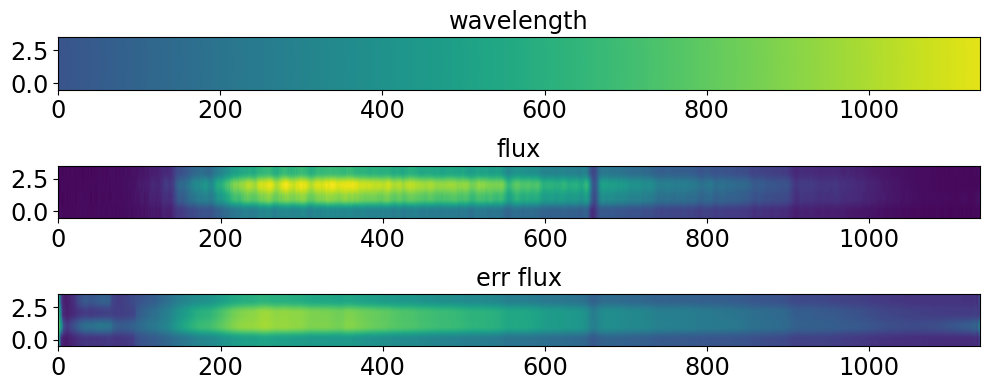

In [117]:
# set up the Axes objects
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(10, 4))

ax1.imshow(X[:,3:],origin='lower',aspect='auto')
ax1.set_title("wavelength")
ax2.imshow(Y[:,:],origin='lower',aspect='auto')
ax2.set_title("flux")
ax3.imshow(EY[:,:],origin='lower',aspect='auto')
ax3.set_title("err flux")
plt.tight_layout()

In [118]:
def FlattenDataCurve(X,Y,Z,ninfo=4):
    
    nwl = X[:,3].astype(int)
    nspec = X.shape[0]

    
    for idx in range (nspec):
        if idx == 0:
            x = X[idx,ninfo:nwl[idx]+ninfo]
            y = Y[idx,:nwl[idx]]
            z = Z[idx,:nwl[idx]]
        else:
            x = np.append(x,X[idx,ninfo:nwl[idx]+ninfo])
            y = np.append(y,Y[idx,:nwl[idx]])
            z = np.append(z,Z[idx,:nwl[idx]])
        
    return x,y,z
    

In [119]:
wlcum,flcum,eflcum = FlattenDataCurve(X,Y,EY,ninfo=NINFO)

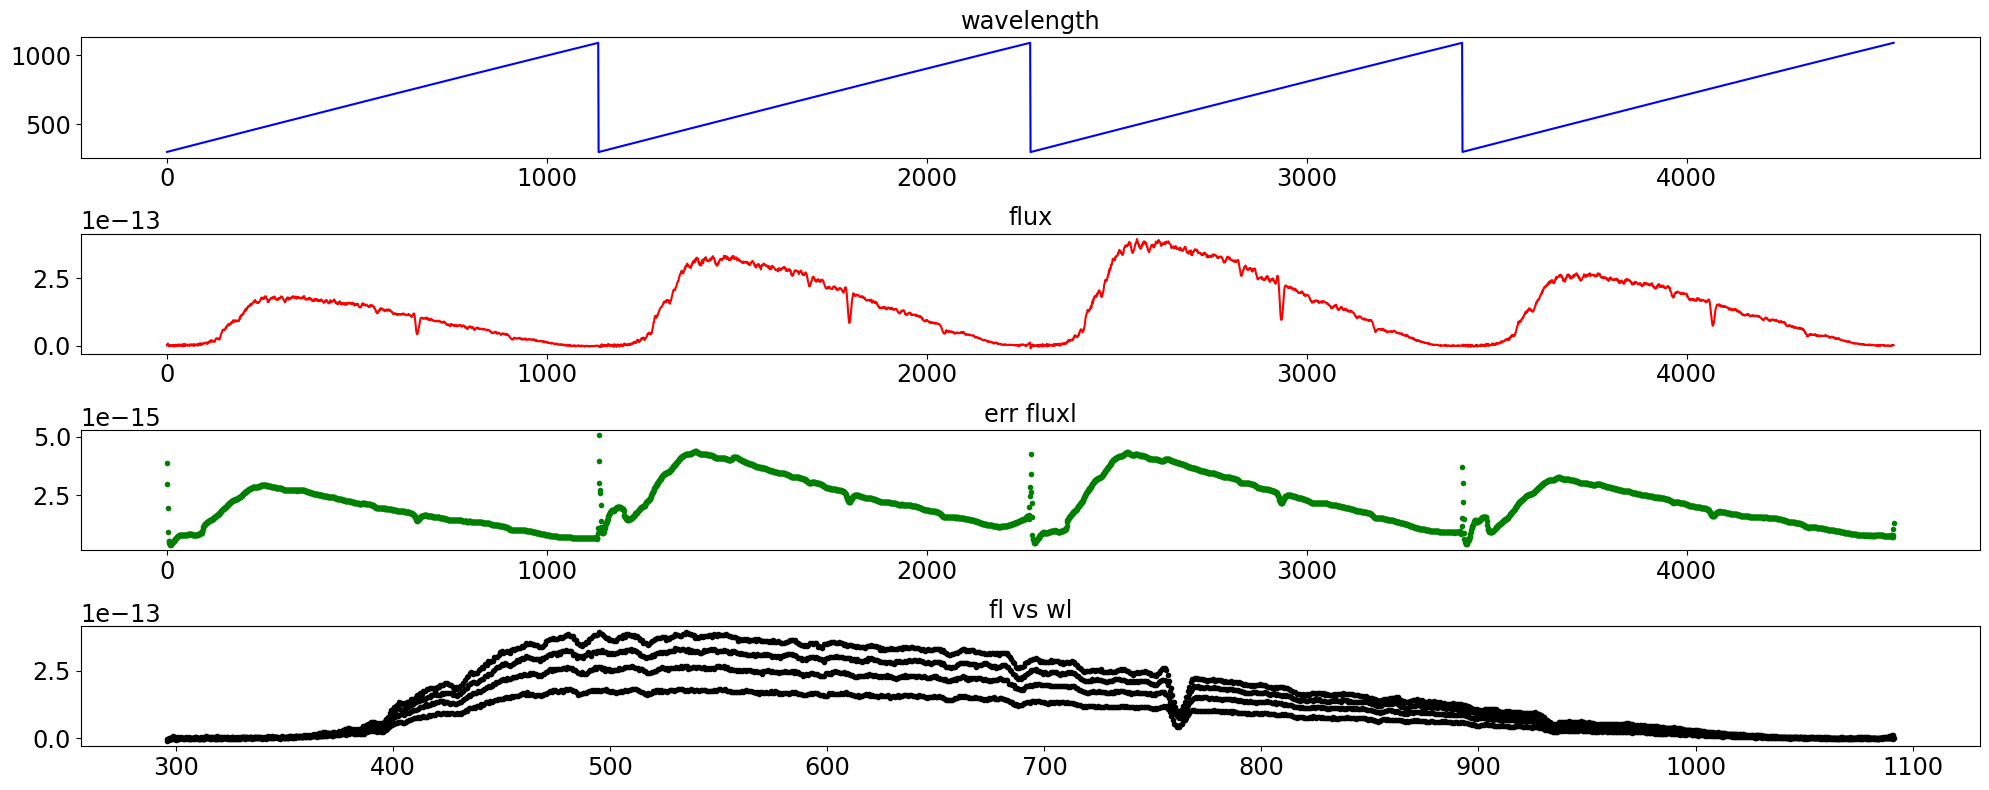

In [120]:
# set up the Axes objects
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, figsize=(20, 8))

ax1.plot(wlcum,'b-')
ax1.set_title("wavelength")
ax2.plot(flcum,'r-')
ax2.set_title("flux")
ax3.plot(eflcum,'g.')
ax3.set_title("err fluxl")
ax4.plot(wlcum,flcum,'k.')
ax4.set_title("fl vs wl")
plt.tight_layout()

# Get smoothed SED

In [121]:
f_sed = dict_f_sed["HD185975"]

# Start the fit of the throughput

In [122]:
#fitter = FitThroughputandAtmosphericParamsCov(WLEXTENDED,f_sed(WLEXTENDED),th,WL.min(),WL.max())
fitter = FitAtmosphericParamsOnlyCov(WLEXTENDED,f_sed(WLEXTENDED),th,WL.min(),WL.max())

Init FitAtmosphericParamsOnlyCov


In [123]:
#popt,pcov,res,myfit=fitter.fitmultievent_greypwvo3aer(X,Y,EY,ninfo = NINFO)

popt,pcov,cf_dict,sigmas,normresiduals,chi2,ndf,chi2_per_ndf = fitter.fitmultievent_greypwvo3aer(X,Y,EY,ninfo = NINFO)

IndexError: index 8 is out of bounds for axis 0 with size 8

In [ ]:
fitter.dfparams

In [ ]:
fitter.paramsbounds

In [ ]:
NPARAMS = len(fitter.params0)
for idx in range(NPARAMS):
    fig = plt.figure(figsize=(20,4))
    valmin = fitter.paramsbounds[0][idx]
    valmax = fitter.paramsbounds[1][idx]
    plt.plot(fitter.dfparams.iloc[idx].values,"b-")
    plt.grid()
    plt.title(fitter.params_names[idx])
    plt.ylim(valmin,valmax)
    plt.show()

# Plots

## Plot data

In [ ]:
# set up the Axes objects
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, figsize=(20, 10))

ax1.plot(fitter.wl,'b-')
ax1.set_title("wavelength")
ax2.plot(fitter.fl,'r-')
ax2.set_title("flux")
ax3.plot(fitter.efl,'g.')
ax3.set_title("err fluxl")
ax4.plot(fitter.wl,fitter.fl,'k.')
ax4.set_title("fl vs wl")
plt.tight_layout()

## Plot initial models

In [ ]:
# set up the Axes objects
fig, ax = plt.subplots(nrows=11, figsize=(20, 25))

ax[0].plot(fitter.wl,'b-')
ax[0].set_title("wavelength")
ax[1].plot(fitter.all_seds,'r-')
ax[1].set_title("sed")
ax[2].plot(fitter.all_throughputs0,'g.')
ax[2].set_title("throughput")
ax[3].plot(fitter.all_atmtransm0,'.',color="orange")
ax[3].set_title("atmospheric transmission")
ax[4].plot(fitter.all_specmodel0,'.',color="cyan")
ax[4].set_title("model")
ax[5].plot(fitter.all_residuals0,'.',color="pink")
ax[5].set_title("residuals")


ax[6].plot(fitter.wl,fitter.all_seds,'k.',ms=0.2)
ax[6].set_title("sed vs wl")
ax[7].plot(fitter.wl,fitter.all_throughputs0,'k.',ms=0.2)
ax[7].set_title("throughputs vs wl")
ax[8].plot(fitter.wl,fitter.all_atmtransm0,'k.',ms=0.2)
ax[8].set_title("atm vs wl")

ax[9].plot(fitter.wl,fitter.all_specmodel0,'k.',ms=0.2)
ax[9].set_title("model vs wl")


ax[10].plot(fitter.wl,fitter.all_residuals0,'k.',ms=0.2)
ax[10].set_title("residuals vs wl")
plt.tight_layout()

In [ ]:
fitter.printinfo()

# Plot final model

In [ ]:
# set up the Axes objects
fig, ax = plt.subplots(nrows=11, figsize=(20, 30))

ax[0].plot(fitter.wl,'b-')
ax[0].set_title("wavelength")
ax[1].plot(fitter.all_seds,'r-')
ax[1].set_title("sed")
ax[2].plot(fitter.all_throughputs,'g.')
ax[2].set_title("throughput")
ax[3].plot(fitter.all_atmtransm,'.',color="orange")
ax[3].set_title("atmospheric transmission")
ax[4].plot(fitter.all_specmodel,'.',color="cyan")
ax[4].set_title("model")
ax[5].plot(fitter.all_residuals,'.',color="pink")
ax[5].set_title("residuals")


ax[6].plot(fitter.wl,fitter.all_seds,'r.',ms=0.2)
ax[6].set_title("sed vs wl")
ax[7].plot(fitter.wl,fitter.all_throughputs,'r.',ms=0.2)
ax[7].plot(fitter.wl,fitter.all_throughputs0,':',color="grey",ms=0.2)
ax[7].set_title("throughputs vs wl")


ax[8].plot(fitter.wl,fitter.all_atmtransm,'k.',ms=0.2)
ax[8].plot(fitter.wl,fitter.all_atmtransm0,'k.',ms=0.2)
ax[8].set_title("atm vs wl")

ax[9].plot(fitter.wl,fitter.all_specmodel,'k.',ms=0.2)
ax[9].set_title("model vs wl")


ax[10].plot(fitter.wl,fitter.all_residuals,'k.',ms=0.2)
ax[10].set_title("residuals vs wl")
plt.tight_layout()

# Save parameters in output file

output_file_h5

In [ ]:
def SaveFitparameterResults(hf_outfile,param_names,params,covariance,infos):
    """
    Save fit result in h5 file
    
    parameters:
     hf_outfile filename of output file
     param_names : array of parameter names
     params : array of fitted values for parameters
     covariance : covariance matrix for parameters
     infos : dataframe containing additional info usefull to save
    """

    hf_outfile =  h5py.File(output_filename_h5, 'w') 
    
    # the indexes
    h5group = hf_outfile.create_group("params_indexes")
    
    h5group.attrs["pwv_idx"] = 0
    h5group.attrs["oz_idx"] = 1
    h5group.attrs["tau_idx"] = 2
    h5group.attrs["beta_idx"] = 3
    h5group.attrs["greys_idx"] = 4
    
    
    # the parameters
    h5group = hf_outfile.create_group("params")
    for idx,param_name in enumerate(param_names):
        key = param_name
        h5group.attrs[key] = params[idx]
        
    #h5group.create_dataset("param_names",data=param_names,compression="gzip", compression_opts=9)
    asciiList = [n.encode("ascii", "ignore") for n in param_names]
    h5group.create_dataset('param_names', (len(asciiList),1),'S10', asciiList)
    
    h5group.create_dataset("param_values",data=params,compression="gzip", compression_opts=9)
    h5group.create_dataset("param_cov",data=covariance,compression="gzip", compression_opts=9)
    
    # the sequence of observations
    h5group = hf_outfile.create_group("obs_sequence")
    
    #dt = [ Time(str_time).to_datetime() for str_time in infos['spec_date_obs'] ]
    dt = [ str_time for str_time in infos['spec_date_obs'] ]
    asciiList = [n.encode("ascii", "ignore") for n in dt]
    numbers = infos['number'].values
    #h5group.create_dataset("datetime",data=dt,compression_opts=9)
    h5group.create_dataset('datetime', (len(asciiList),1),'S20', asciiList)
    h5group.create_dataset("numbers",data=numbers,compression="gzip",compression_opts=9)
    
    
    print(hf_outfile.keys())
    hf_outfile.close()     
     

In [ ]:
SaveFitparameterResults(output_filename_h5,fitter.params_names,popt,pcov,infos)

# Time dependence

In [ ]:
all_datetime = [ Time(str_time).to_datetime() for str_time in infos['spec_date_obs'] ]
numbers = infos['number'].values

In [ ]:
fitter.params_names

In [ ]:
greys = popt[4:4+NBSPECTRA]
ngreys = len(greys)
greys_err = np.sqrt(np.diag(pcov))[4:4+NBSPECTRA]

aer = [popt[2]]
aer_err = [np.sqrt(np.diag(pcov))[2]]
naer = 1

fig =plt.figure(figsize=(16,5))
ax = fig.add_subplot(1,1,1)
ax.errorbar(np.arange(ngreys),greys,yerr=greys_err,fmt='o',color="r",label="grey attenuation")


ax.errorbar(np.arange(naer),aer,yerr=aer_err,fmt='o',color="b",label="aer attenuation")

ax.grid()
ax.set_title("grey optical depth")
ax.set_xlabel("observation number")
ax.set_ylabel("grey optical depth")
ax.set_ylim(0.,np.max(greys)*1.2)
ax.legend()

In [ ]:
greys = popt[4:4+NBSPECTRA]
ngreys = len(greys)
greys_err = np.sqrt(np.diag(pcov))[4:4+NBSPECTRA]

aer = [popt[2]]
aer_err = [np.sqrt(np.diag(pcov))[2]]
naer = 1

fig =plt.figure(figsize=(16,5))


# First axis : grey attenuation vs UTC date
#===========================================
ax = fig.add_subplot(1,1,1)
ax.errorbar(all_datetime ,greys,yerr=greys_err,fmt='o',color="r",label="grey attenuation")
fmt = '%m/%d %H:%M'
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter(fmt))
ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
ax.tick_params(which='major', width=1.00, length=5)
ax.tick_params(which='minor', width=0.75, length=2.5)
ax.grid(True)
#plt.gcf().autofmt_xdate()  # orient date labels at a slant
# slant for this axis
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')

ax.set_xlabel("UTC Time")


#ax.errorbar(np.arange(naer),aer,yerr=aer_err,fmt='o',color="b",label="aer attenuation")

title=f"Fitted Grey optical index at {DATE} ({FILTERTYPE})"
ax.set_title(title)

ax.set_ylabel("grey optical depth")
ax.set_ylim(0.,np.max(greys)*1.2)
ax.legend()

ymin,ymax  = ax.get_ylim()
yscale = ymax-ymin
y_shift = yscale/10.

for index in range(NBSPECTRA):
    textstr= str(numbers[index])
    if index%2 == 0:
        dy = y_shift
    else:
        dy = -y_shift
            
    ax.text(all_datetime[index], greys[index] + dy , textstr,fontsize=14,fontweight="bold",ha='center',color="b" )

# Second axis shown as an example for ticks and label position shifing from 
# https://github.com/sylvielsstfr/AuxtelStarAlt/blob/main/notebooks/2023-09-12/ObservationOfVisibleCalspecList.ipynb
# ================================

# should plot something like the relative time from the beginning for the ax2-X axis

ax2 = ax.twiny()
# Move twinned axis ticks and label from top to bottom
ax2.xaxis.set_ticks_position("bottom")
ax2.xaxis.set_label_position("bottom")
# Offset the twin axis below the host
offset = -0.4
ax2.spines["bottom"].set_position(("axes", offset))

ax2.set_frame_on(True)
ax2.patch.set_visible(False) # mandatory
for sp in ax2.spines.values():
    sp.set_visible(False)

# Confidence interval ellipses

## Calculate covariance/correlation matrix
https://stackoverflow.com/questions/62213236/error-converting-covariance-to-correlation-using-scipy

In [ ]:
# cov to cor
def cov2cor(c):
    """
    Return a correlation matrix given a covariance matrix. 
    : c = covariance matrix
    """
    D = 1 / np.sqrt(np.diag(c)) # takes the inverse of sqrt of diag.
    return D * c * D

# print(cov2cor(a))
# print(cov2cor(c=a))

In [ ]:
# cor to cov
def cor2cov(c, s):
    """
    Return a covariance matrix given a correlation matrix 
    and standard deviations.
    : c = covariance matrix
    : s = standard deviation
    """
    D = np.diag(s)
    return D * c * D
    
# a = cor2cov(c=r, s=stdev)
# print(a)

In [ ]:
NPARAMS = popt.shape[0]
NPARAMS 

In [ ]:
corr_mat = cov2cor(pcov)

In [ ]:
plt.imshow(corr_mat,cmap="seismic")

In [ ]:
sns.heatmap(corr_mat,annot=True)

https://stackoverflow.com/questions/20126061/creating-a-confidence-ellipse-in-a-scatterplot-using-matplotlib

In [ ]:
def get2paramscovmatrix(idx,idy,pcov):
    covxy = [[pcov[idx,idx], pcov[idx,idy]],[pcov[idy,idx], pcov[idy,idy]] ]
    covxy = np.array(covxy)
    return covxy

In [ ]:
def plotconfidenceellipse(mx,my,cov,nstd,ax):
    """
    https://stackoverflow.com/questions/20126061/creating-a-confidence-ellipse-in-a-scatterplot-using-matplotlib
    There is no need to compute angles explicitly once you have the eigendecomposition of your covariance matrix: the rotation portion already encodes that information for you for free:
    """

    val, rot = np.linalg.eig(cov)
    val = np.sqrt(val)
    #center = np.array([mx, my], axis=1)[:, None]
    center = np.array([mx, my])[:, None]

    t = np.linspace(0, 2.0 * np.pi, 1000)
    xy = np.stack((np.cos(t), np.sin(t)), axis=-1)

    ax.scatter([mx], [my])
    ax.plot(*(nstd * rot @ (val * xy).T + center))


In [ ]:
fitter.params_names

In [ ]:
fitter.params_names.shape

## Choose the parameters

In [ ]:
def PlotConfidenceIntervals(idx,idy,cov):
    """
    
    Plot confidence interval ellipses between two parameters
    
    """
    mean_x = popt[idx]
    mean_y = popt[idy]
    name_x = fitter.params_names[idx]
    name_y = fitter.params_names[idy]
    
    covxy =  get2paramscovmatrix(idx,idy,cov)
    sigmas = np.sqrt(np.diag(covxy))
    
    
    fig =plt.figure()
    ax= fig.add_subplot(1,1,1)
    ax.scatter([mean_x],[mean_y])
    sns.color_palette("hls", 4)
    for nstd in range(1, 4):
        plotconfidenceellipse(mean_x,mean_y,covxy,nstd,ax)
    ax.grid()
    ax.set_xlabel(name_x)
    ax.set_ylabel(name_y)
    ax.axvline(mean_x,color="k")
    ax.axhline(mean_y,color="k")
    ax.legend()
    title = f"{name_y} vs {name_x}"
    ax.set_title(title)
    plt.show()   
    

In [ ]:
idx = 0
idy = 2

In [ ]:
PlotConfidenceIntervals(idx,idy,pcov)

In [ ]:
for idy in range(idx+1,NPARAMS):
    PlotConfidenceIntervals(idx,idy,pcov)